### IMPORTS

In [224]:
import pandas as pd
import numpy as np
import sys
import os
import importlib
import phik

import matplotlib.pyplot as plt
import seaborn as sns

ruta_utils = os.path.abspath("../utils")
sys.path.append(ruta_utils)
import Toolbox_datascience as tds
from Pipeline_utils import FeatureEngineer

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score



In [225]:
importlib.reload(tds)

<module 'Toolbox_datascience' from 'c:\\Users\\rodri\\Git_Repositories\\Project_Break_II\\src\\utils\\Toolbox_datascience.py'>

### LOAD TRAIN DATA

In [226]:
df = pd.read_csv("../data/Train_data/train_data.csv")
df.columns = df.columns.str.replace(' ', '_')
df.set_index("SEQN", inplace=True)
df.head()

Gender  Age(year)  Race  Country_of_birth  Income_category  \
SEQN                                                                  
31131.0     2.0       44.0   4.0               1.0              4.0   
31132.0     1.0       70.0   3.0               1.0              5.0   
31150.0     1.0       79.0   3.0               1.0              2.0   
31151.0     2.0       59.0   4.0               1.0              4.0   
31153.0     2.0       44.0   5.0               1.0              2.0   

         Height(m)  Weight(kg)  HDL-Cholesterol(mmol/L)  \
SEQN                                                      
31131.0     1.5240   74.389088                     1.01   
31132.0     1.7272   69.853168                     1.53   
31150.0     1.7526   86.182480                     2.09   
31151.0     1.7018   81.646560                     1.97   
31153.0     1.6764  104.326160                     1.29   

         Total_Cholesterol(mmol/L)  Glycohemoglobin(%)  Insulin_(pmol/L)  \
SEQN                                                                       
31131.0                       2.72                 6.0             60.18   
31132.0                       3.80                 7.1             53.94   
31150.0                       4.68                 5.0             23.46   
31151.0                       5.30                 5.8             36.18   
31153.0                       5.12                 4.6            125.88   

         High_blood_pressure?  100_cigarrettes_life?  Diabetes_diagnosticated  
SEQN                                                                           
31131.0                   1.0                    2.0                      0.0  
31132.0                   1.0                    2.0                      1.0  
31150.0                   2.0                    1.0                      0.0  
31151.0                   1.0                    1.0                      1.0  
31153.0                   1.0                    1.0                      0.0

Establish target

In [227]:
target = 'Diabetes_diagnosticated'

### Target distribution

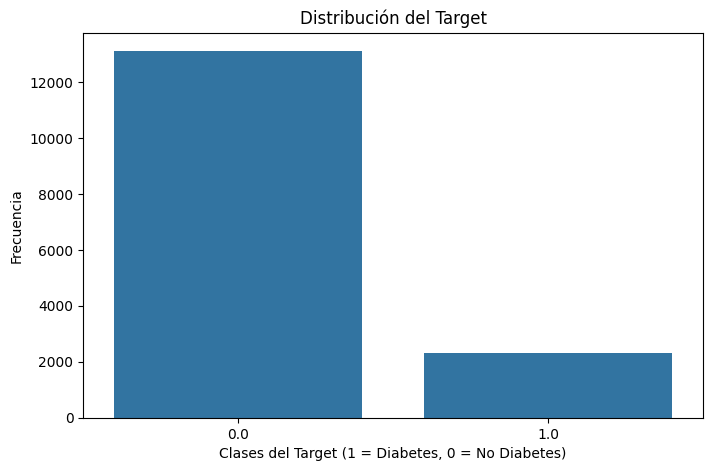

In [228]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Diabetes_diagnosticated"])  # Gráfico de barras para contar categorías
plt.xlabel("Clases del Target (1 = Diabetes, 0 = No Diabetes)")
plt.ylabel("Frecuencia")
plt.title("Distribución del Target")
plt.show()


In [216]:
df[target].value_counts(normalize=True) * 100

Diabetes_diagnosticated
0.0    85.08567
1.0    14.91433
Name: proportion, dtype: float64

### New features (feature engineering)

In [ ]:
# Cálculo del IMC (Índice de Masa Corporal)
df['BMI'] = df['Weight(kg)'] / (df['Height(m)'] ** 2)

# Ratio Colesterol Total / HDL (indicador de riesgo cardiovascular)
df['CHOL_ratio'] = df['Total_Cholesterol(mmol/L)'] / df['HDL-Cholesterol(mmol/L)']

# Agrupar edad en categorías clínicas
def age_group(age):
    if age < 18:
        return 1.0 #'child'
    elif age < 40:
        return 2.0 #'young_adult'
    elif age < 60:
        return 3.0 #'adult'
    else:
        return 4.0 #'senior'
df['Age_group'] = df['Age(year)'].apply(age_group)

# Categorías de IMC según la OMS
def bmi_category(bmi):
    if bmi < 18.5:
        return 1.0 #'underweight'
    elif bmi < 25:
        return 2.0 #'normal'
    elif bmi < 30:
        return 3.0 #'overweight'
    else:
        return 4.0 #'obese'
df['BMI_category'] = df['BMI'].apply(bmi_category)

# Indicador binario de colesterol total elevado
df['High_cholesterol'] = (df['Total_Cholesterol(mmol/L)'] > 6.2).astype(int)

# Indicador binario de HbA1c elevado (≥ 6.5% → diagnóstico de diabetes)
df['High_HbA1c'] = (df['Glycohemoglobin(%)'] >= 6.5).astype(int)

# Interacción IMC x HbA1c
df['BMI_HbA1c'] = df['BMI'] * df['Glycohemoglobin(%)']

# Indicador binario de insulina alta (posible resistencia a insulina)
df['High_insulin'] = (df['Insulin_(pmol/L)'] > 90).astype(int)

# Indicador de riesgo cardiovascular simple (edad alta, IMC alto, colesterol alto, hipertensión)
df['Cardio_risk'] = (
    (df['Age(year)'] > 60).astype(int) +
    (df['BMI'] > 30).astype(int) +
    (df['Total_Cholesterol(mmol/L)'] > 6.2).astype(int) +
    (df['High_blood_pressure?'] == 1).astype(int)
)

df.head()

df.to_csv("../data/Train_data/train_data_cleaned.csv", index = False)


# pipe = Pipeline([
#     ('feature_engineering', FeatureEngineer())
#     ])

### Split in train and test

In [230]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(target, axis=1),
                                                    df[target],
                                                    test_size=0.2,
                                                    random_state=42)

### Describe variables

In [231]:
tds.describe_df(X_train)

COL_N           Gender Age(year)     Race Country_of_birth Income_category  \
DATA_TYPE      float64   float64  float64          float64         float64   
MISSINGS (%)       0.0       0.0      0.0              0.0             0.0   
UNIQUE_VALUES        2        68        5                2               5   
CARDIN (%)         0.0      0.01      0.0              0.0             0.0   

COL_N         Height(m) Weight(kg) HDL-Cholesterol(mmol/L)  \
DATA_TYPE       float64    float64                 float64   
MISSINGS (%)        0.0        0.0                     0.0   
UNIQUE_VALUES        33        282                     135   
CARDIN (%)          0.0       0.02                    0.01   

COL_N         Total_Cholesterol(mmol/L) Glycohemoglobin(%)  ...  \
DATA_TYPE                       float64            float64  ...   
MISSINGS (%)                        0.0                0.0  ...   
UNIQUE_VALUES                       290                109  ...   
CARDIN (%)                         0.02               0.01  ...   

COL_N         100_cigarrettes_life?      BMI CHOL_ratio Age_group  \
DATA_TYPE                   float64  float64    float64   float64   
MISSINGS (%)                    0.0      0.0        0.0       0.0   
UNIQUE_VALUES                     2     2450       6329         3   
CARDIN (%)                      0.0      0.2       0.51       0.0   

COL_N         BMI_category High_cholesterol High_HbA1c BMI_HbA1c High_insulin  \
DATA_TYPE          float64            int32      int32   float64        int32   
MISSINGS (%)           0.0              0.0        0.0       0.0          0.0   
UNIQUE_VALUES            4                2          2      8686            2   
CARDIN (%)             0.0              0.0        0.0       0.7          0.0   

COL_N         Cardio_risk  
DATA_TYPE           int32  
MISSINGS (%)          0.0  
UNIQUE_VALUES           5  
CARDIN (%)            0.0  

[4 rows x 22 columns]

In [232]:
df_cardinalidad = tds.clasifica_variables(X_train,10,10)
df_cardinalidad

nombre_variable      tipo_sugerido
0                      Gender            Binaria
1                   Age(year)  Numérica Discreta
2                        Race         Categórica
3            Country_of_birth            Binaria
4             Income_category         Categórica
5                   Height(m)  Numérica Discreta
6                  Weight(kg)  Numérica Discreta
7     HDL-Cholesterol(mmol/L)  Numérica Discreta
8   Total_Cholesterol(mmol/L)  Numérica Discreta
9          Glycohemoglobin(%)  Numérica Discreta
10           Insulin_(pmol/L)  Numérica Discreta
11       High_blood_pressure?            Binaria
12      100_cigarrettes_life?            Binaria
13                        BMI  Numérica Discreta
14                 CHOL_ratio  Numérica Discreta
15                  Age_group         Categórica
16               BMI_category         Categórica
17           High_cholesterol            Binaria
18                 High_HbA1c            Binaria
19                  BMI_HbA1c  Numérica Discreta
20               High_insulin            Binaria
21                Cardio_risk         Categórica

### Establish features categorical and numerical

In [233]:
cat_features = df_cardinalidad['nombre_variable'][(df_cardinalidad['tipo_sugerido'] == 'Categórica') | (df_cardinalidad['tipo_sugerido'] == 'Binaria')].tolist()
num_features = df_cardinalidad['nombre_variable'][(df_cardinalidad['tipo_sugerido'] == 'Numérica Discreta')].tolist()
print(num_features)
print(cat_features)

['Age(year)', 'Height(m)', 'Weight(kg)', 'HDL-Cholesterol(mmol/L)', 'Total_Cholesterol(mmol/L)', 'Glycohemoglobin(%)', 'Insulin_(pmol/L)', 'BMI', 'CHOL_ratio', 'BMI_HbA1c']
['Gender', 'Race', 'Country_of_birth', 'Income_category', 'High_blood_pressure?', '100_cigarrettes_life?', 'Age_group', 'BMI_category', 'High_cholesterol', 'High_HbA1c', 'High_insulin', 'Cardio_risk']


### Lineal correlation

In [222]:
corr = np.abs(df.corr()[target]).sort_values(ascending=True)
print(corr)

bad_corr_feat = corr[corr < 0.2].index.values
print(bad_corr_feat)


Country_of_birth             0.002217
Height(m)                    0.015959
Race                         0.015997
High_cholesterol             0.030837
Gender                       0.032860
CHOL_ratio                   0.040194
Income_category              0.043992
100_cigarrettes_life?        0.047556
Total_Cholesterol(mmol/L)    0.096073
HDL-Cholesterol(mmol/L)      0.119571
High_insulin                 0.126565
Insulin_(pmol/L)             0.161541
Weight(kg)                   0.171028
BMI_category                 0.190412
BMI                          0.200864
High_blood_pressure?         0.279285
Age(year)                    0.282112
Age_group                    0.283767
Cardio_risk                  0.314405
BMI_HbA1c                    0.480956
Glycohemoglobin(%)           0.584311
High_HbA1c                   0.638080
Diabetes_diagnosticated      1.000000
Name: Diabetes_diagnosticated, dtype: float64
['Country_of_birth' 'Height(m)' 'Race' 'High_cholesterol' 'Gender'
 'CHOL_ratio'

### Feature importance with Random Forest

In [234]:

#Load boston housing dataset as an example
X = df.drop([target], axis = 1)
Y = df.Diabetes_diagnosticated

rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X, Y)

names = X.columns
scores = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True)
pd.DataFrame(scores, columns=['Score', 'Feature'])

Score                    Feature
0   0.4588         Glycohemoglobin(%)
1   0.0656           Insulin_(pmol/L)
2   0.0635  Total_Cholesterol(mmol/L)
3   0.0573                 CHOL_ratio
4   0.0465                  Age(year)
5   0.0450                  BMI_HbA1c
6   0.0394                 Weight(kg)
7   0.0379    HDL-Cholesterol(mmol/L)
8   0.0365                        BMI
9   0.0332                 High_HbA1c
10  0.0330                  Height(m)
11  0.0186                       Race
12  0.0177            Income_category
13  0.0124       High_blood_pressure?
14  0.0103                Cardio_risk
15  0.0057      100_cigarrettes_life?
16  0.0056           Country_of_birth
17  0.0044                     Gender
18  0.0034                  Age_group
19  0.0022               BMI_category
20  0.0021               High_insulin
21  0.0008           High_cholesterol

### Statistic feature Importance

In [ ]:

print(X.shape)
sel = SelectKBest(k=5)
X_new = sel.fit_transform(X, Y)
print(X_new.shape)
print(sel.scores_)

pd.DataFrame({'column': names, 'score': sel.scores_}).sort_values('score', ascending=False)

(15408, 22)
(15408, 5)
[1.66532100e+01 1.33214280e+03 3.94370019e+00 7.57481862e-02
 2.98734098e+01 3.92453601e+00 4.64215194e+02 2.23458495e+02
 1.43523168e+02 7.98674636e+03 4.12799430e+02 1.30332503e+03
 3.49201457e+01 6.47710125e+02 2.49291018e+01 1.34919005e+03
 5.79583179e+02 1.46637775e+01 1.05801415e+04 4.63610927e+03
 2.50800040e+02 1.68993954e+03]


column         score
18                 High_HbA1c  10580.141491
9          Glycohemoglobin(%)   7986.746365
19                  BMI_HbA1c   4636.109271
21                Cardio_risk   1689.939544
15                  Age_group   1349.190052
1                   Age(year)   1332.142802
11       High_blood_pressure?   1303.325027
13                        BMI    647.710125
16               BMI_category    579.583179
6                  Weight(kg)    464.215194
10           Insulin_(pmol/L)    412.799430
20               High_insulin    250.800040
7     HDL-Cholesterol(mmol/L)    223.458495
8   Total_Cholesterol(mmol/L)    143.523168
12      100_cigarrettes_life?     34.920146
4             Income_category     29.873410
14                 CHOL_ratio     24.929102
0                      Gender     16.653210
17           High_cholesterol     14.663777
2                        Race      3.943700
5                   Height(m)      3.924536
3            Country_of_birth      0.075748

### Logaritmic transformation

In [235]:
X_train['Insulin_(pmol/L)'] = np.log1p(X_train['Insulin_(pmol/L)'])
X_train['Glycohemoglobin(%)'] = np.log1p(X_train['Glycohemoglobin(%)'])
X_train['BMI'] = np.log1p(X_train['BMI'])
X_train['CHOL_ratio'] = np.log1p(X_train['CHOL_ratio'])
X_train['BMI_HbA1c'] = np.log1p(X_train['BMI_HbA1c'])
X_train['HDL-Cholesterol(mmol/L)'] = np.log1p(X_train['HDL-Cholesterol(mmol/L)'])
X_train['Total_Cholesterol(mmol/L)'] = np.log1p(X_train['Total_Cholesterol(mmol/L)'])

X_test['Insulin_(pmol/L)'] = np.log1p(X_test['Insulin_(pmol/L)'])
X_test['Glycohemoglobin(%)'] = np.log1p(X_test['Glycohemoglobin(%)'])
X_test['BMI'] = np.log1p(X_test['BMI'])
X_test['CHOL_ratio'] = np.log1p(X_test['CHOL_ratio'])
X_test['BMI_HbA1c'] = np.log1p(X_test['BMI_HbA1c'])
X_test['HDL-Cholesterol(mmol/L)'] = np.log1p(X_test['HDL-Cholesterol(mmol/L)'])
X_test['Total_Cholesterol(mmol/L)'] = np.log1p(X_test['Total_Cholesterol(mmol/L)'])

### Univariant analysis numeric features

c:\Users\rodri\Git_Repositories\Project_Break_II\src\utils\Toolbox_datascience.py:433: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, bins=bins, kde=kde, ax=ax, hue=df[hue] if hue else None, palette='coolwarm')
c:\Users\rodri\Git_Repositories\Project_Break_II\src\utils\Toolbox_datascience.py:433: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, bins=bins, kde=kde, ax=ax, hue=df[hue] if hue else None, palette='coolwarm')
c:\Users\rodri\Git_Repositories\Project_Break_II\src\utils\Toolbox_datascience.py:433: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, bins=bins, kde=kde, ax=ax, hue=df[hue] if hue else None, palette='coolwarm')
c:\Users\rodri\Git_Repositories\Project_Break_II\src\utils\Toolbox_datascience.py:433: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=

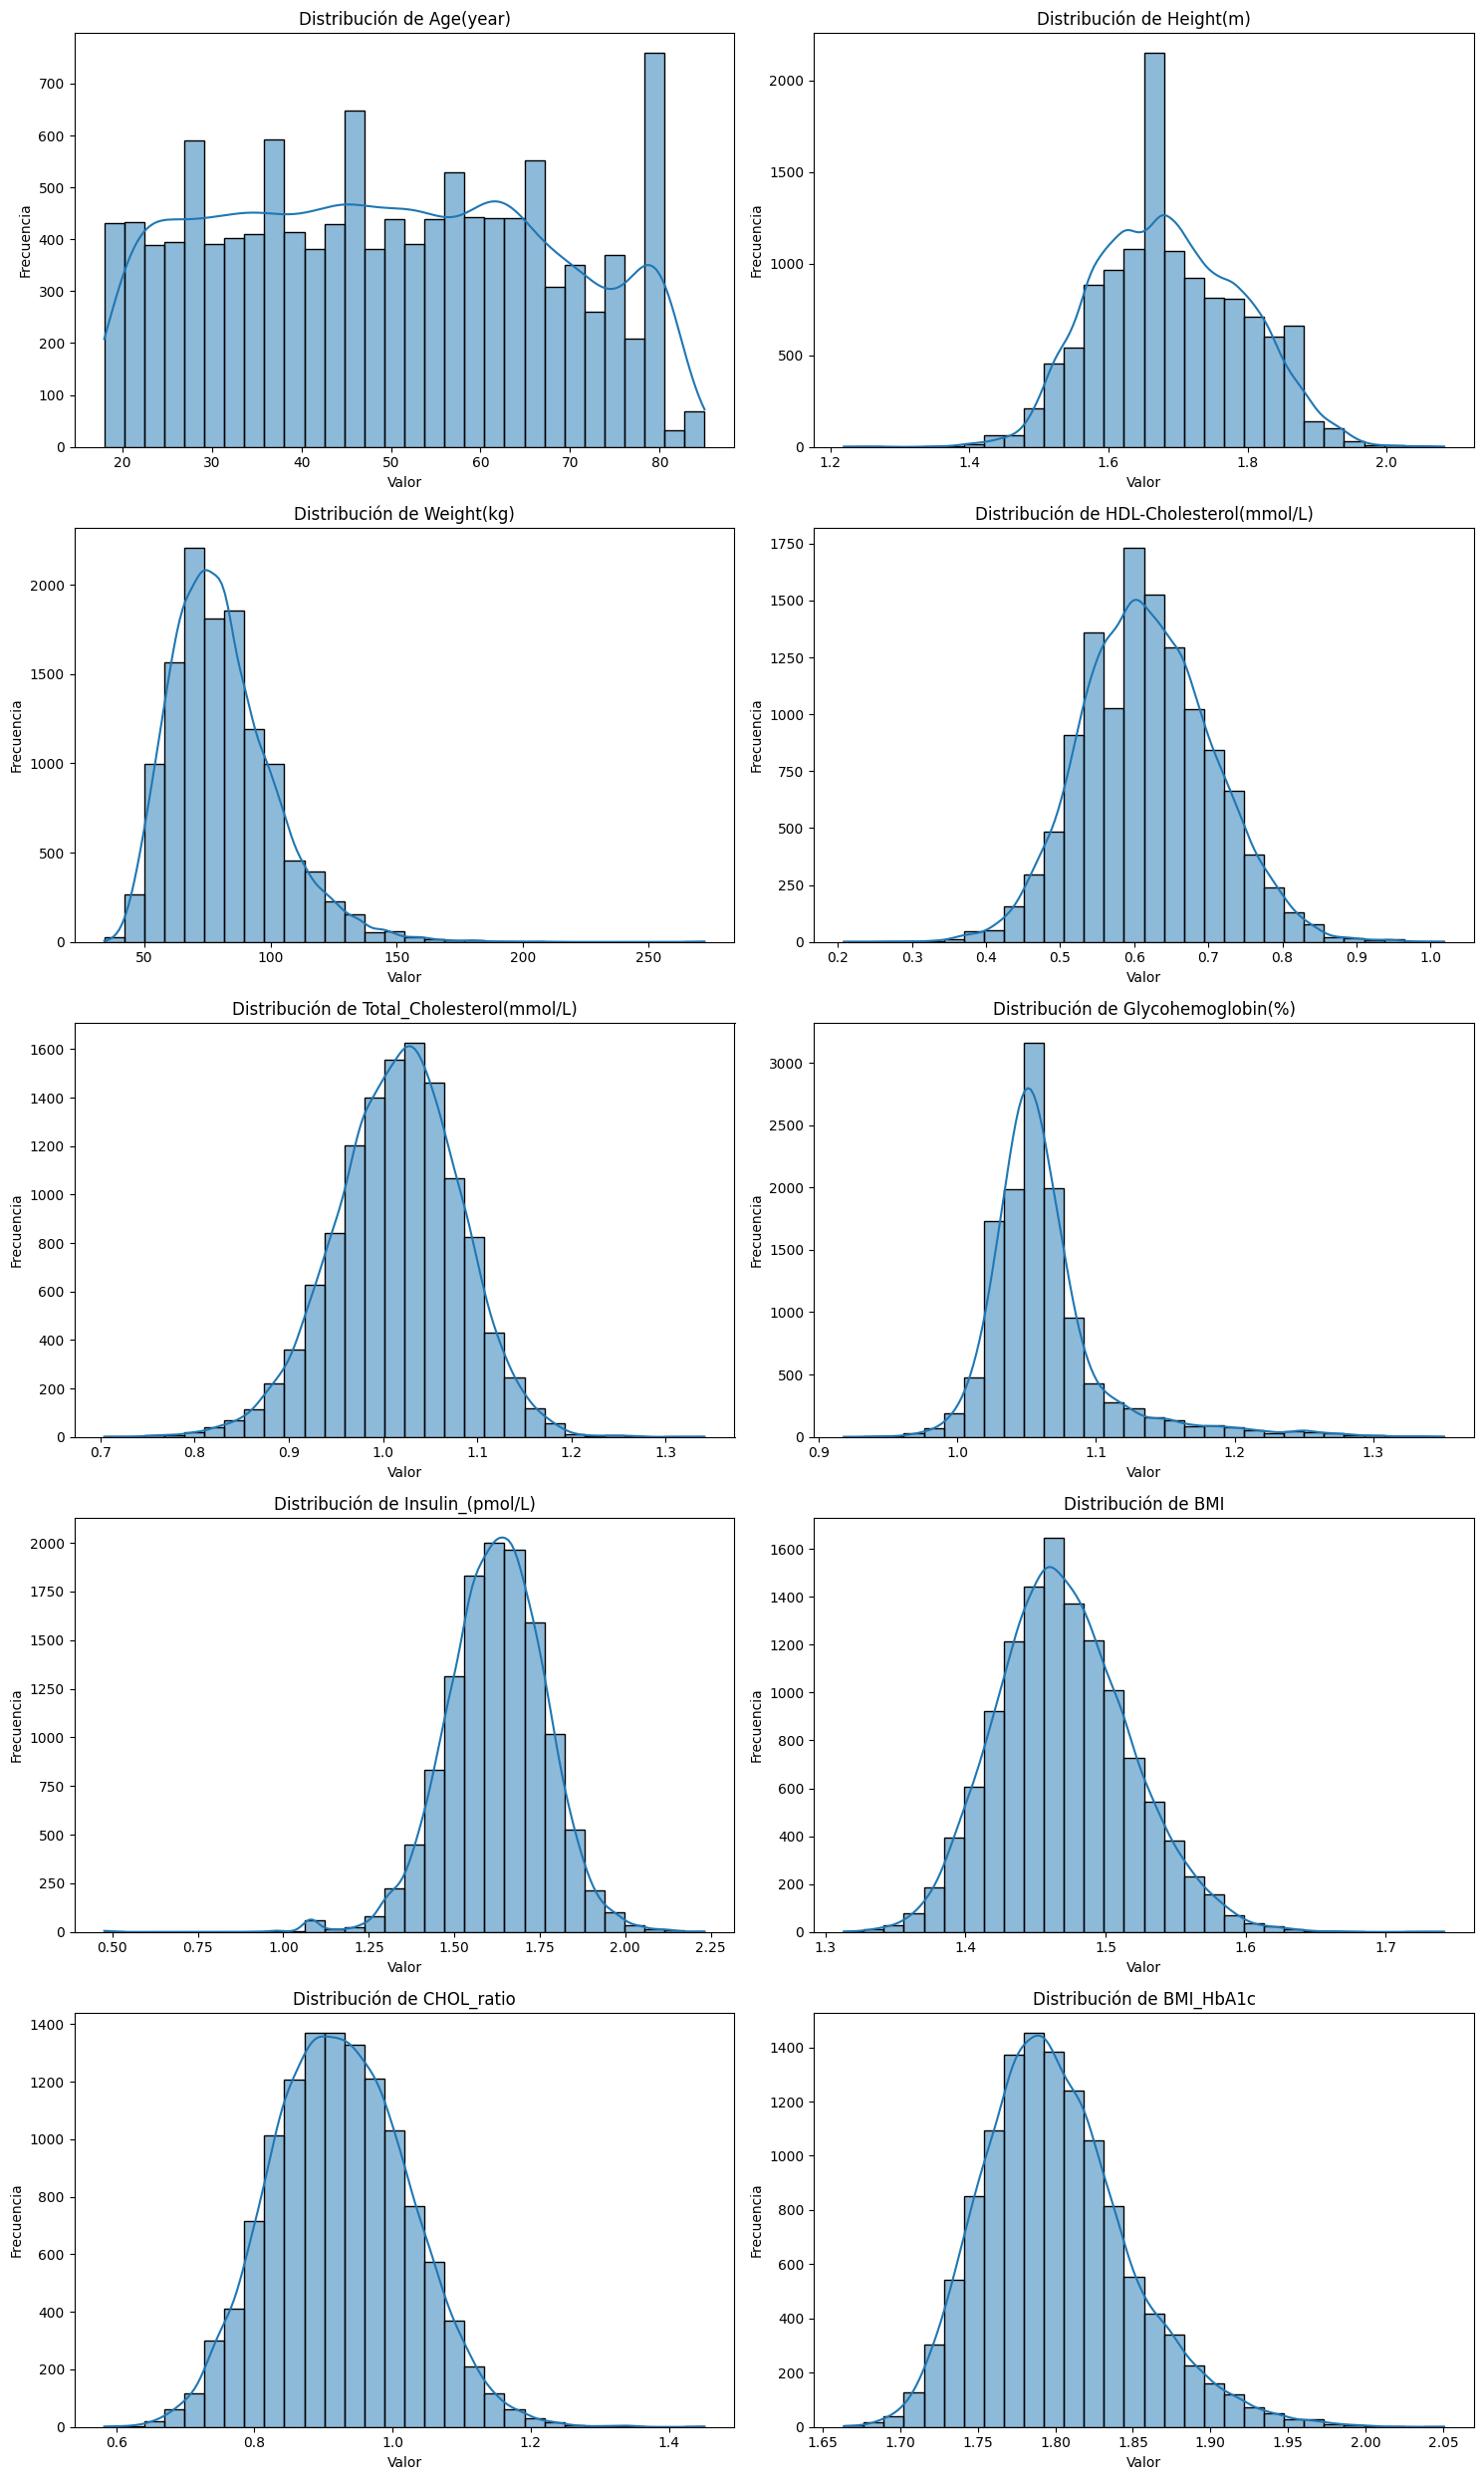

In [ ]:
tds.pinta_distribucion_numericas(X_train, num_features)

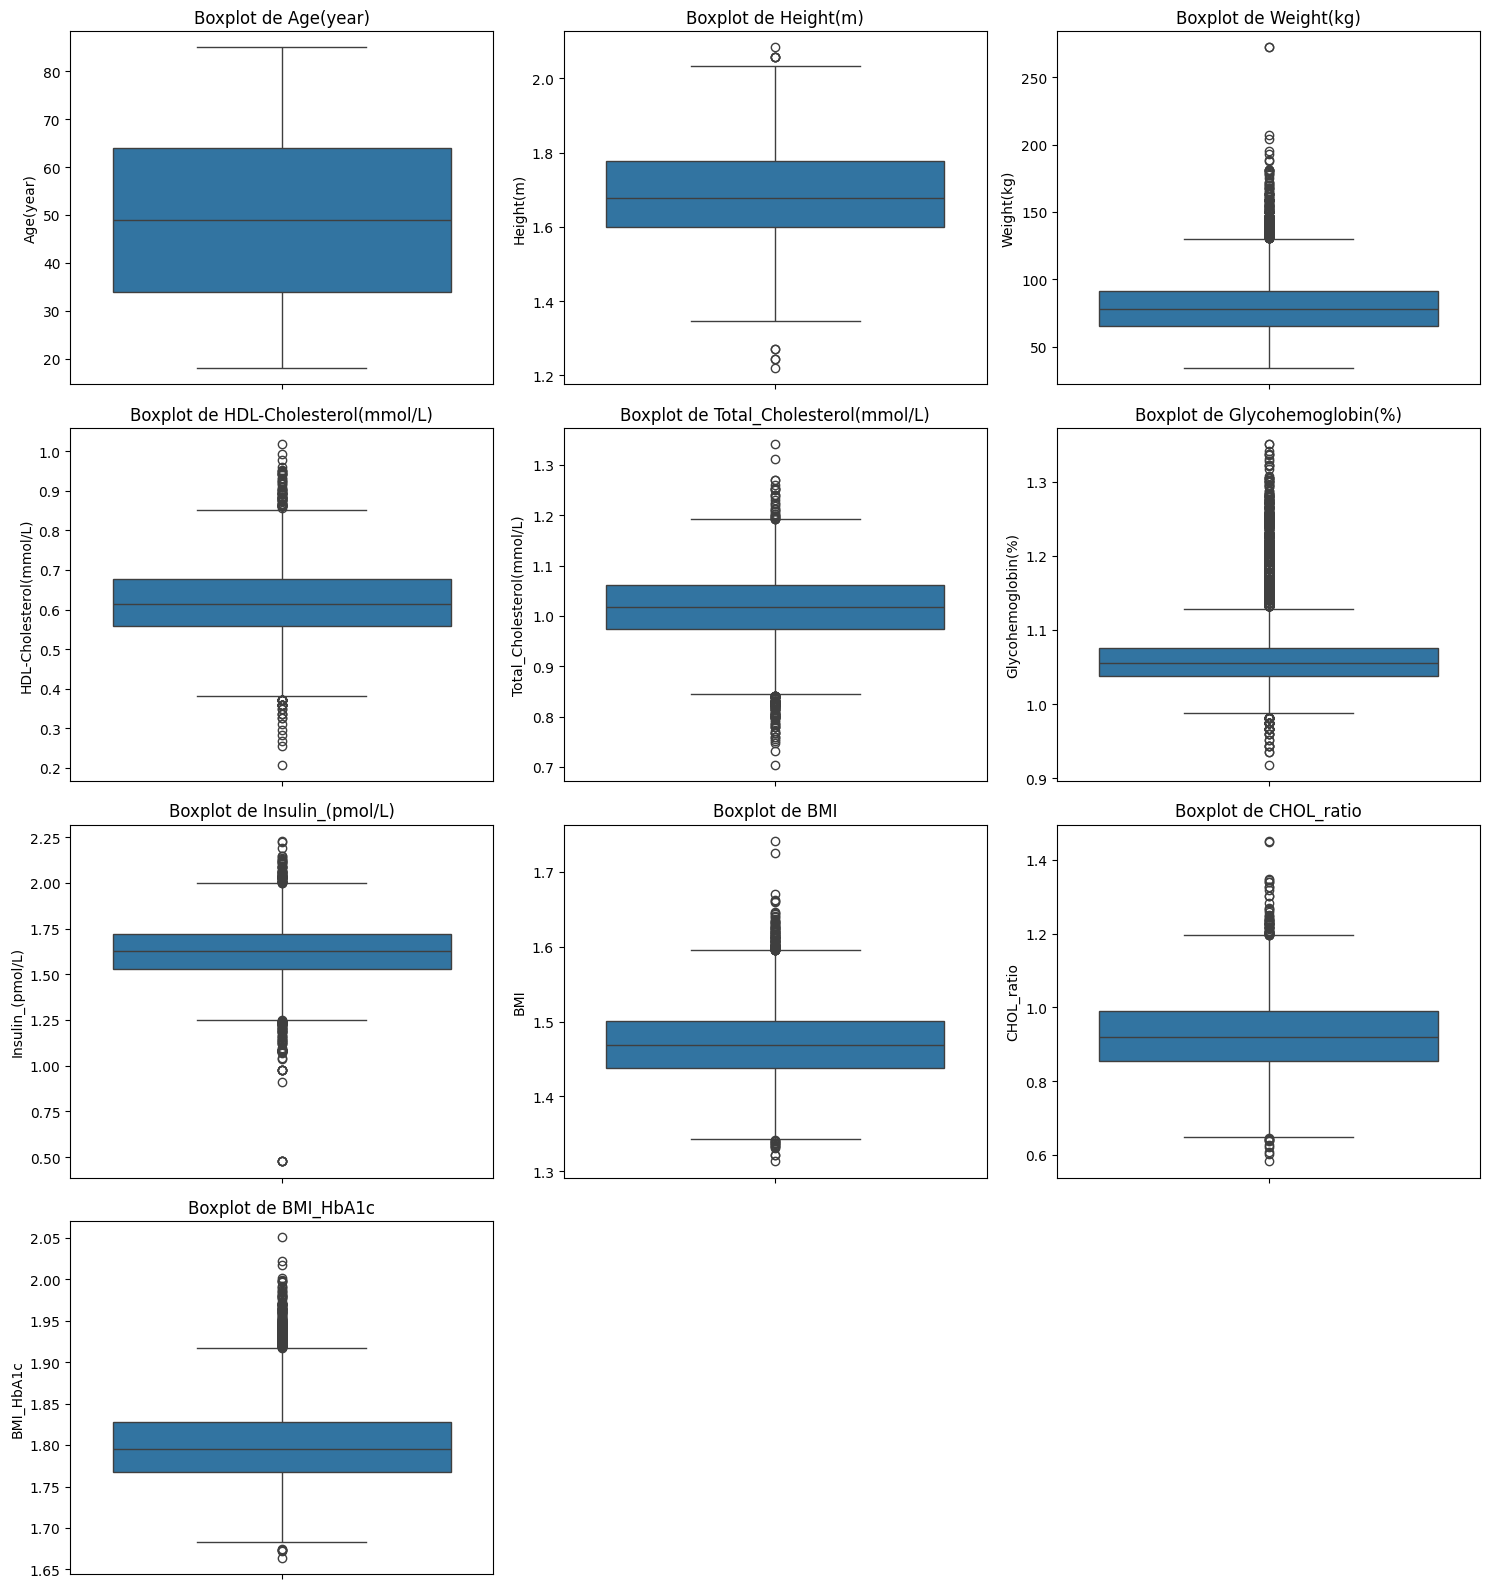

In [ ]:

# Obtener las columnas numéricas
num_cols = X_train[num_features].columns

# Definir el tamaño de la grilla (ejemplo: 3 filas x 3 columnas)
n_cols = 3  # Número de columnas en la cuadrícula
n_rows = int(np.ceil(len(num_cols) / n_cols))  # Calcula las filas necesarias

# Crear la figura con subgráficos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))

# Asegurar que 'axes' sea un array plano para iterar fácilmente
axes = axes.flatten()

# Iterar sobre cada variable y crear un boxplot en la posición correspondiente
for i, col in enumerate(num_cols):
    sns.boxplot(y=X_train[col], ax=axes[i])
    axes[i].set_title(f"Boxplot de {col}")

# Ocultar los ejes vacíos (si hay más subplots que columnas)
for i in range(len(num_cols), len(axes)):
    fig.delaxes(axes[i])  # Elimina los gráficos vacíos

plt.tight_layout()  # Ajusta el espacio entre gráficos
plt.show()


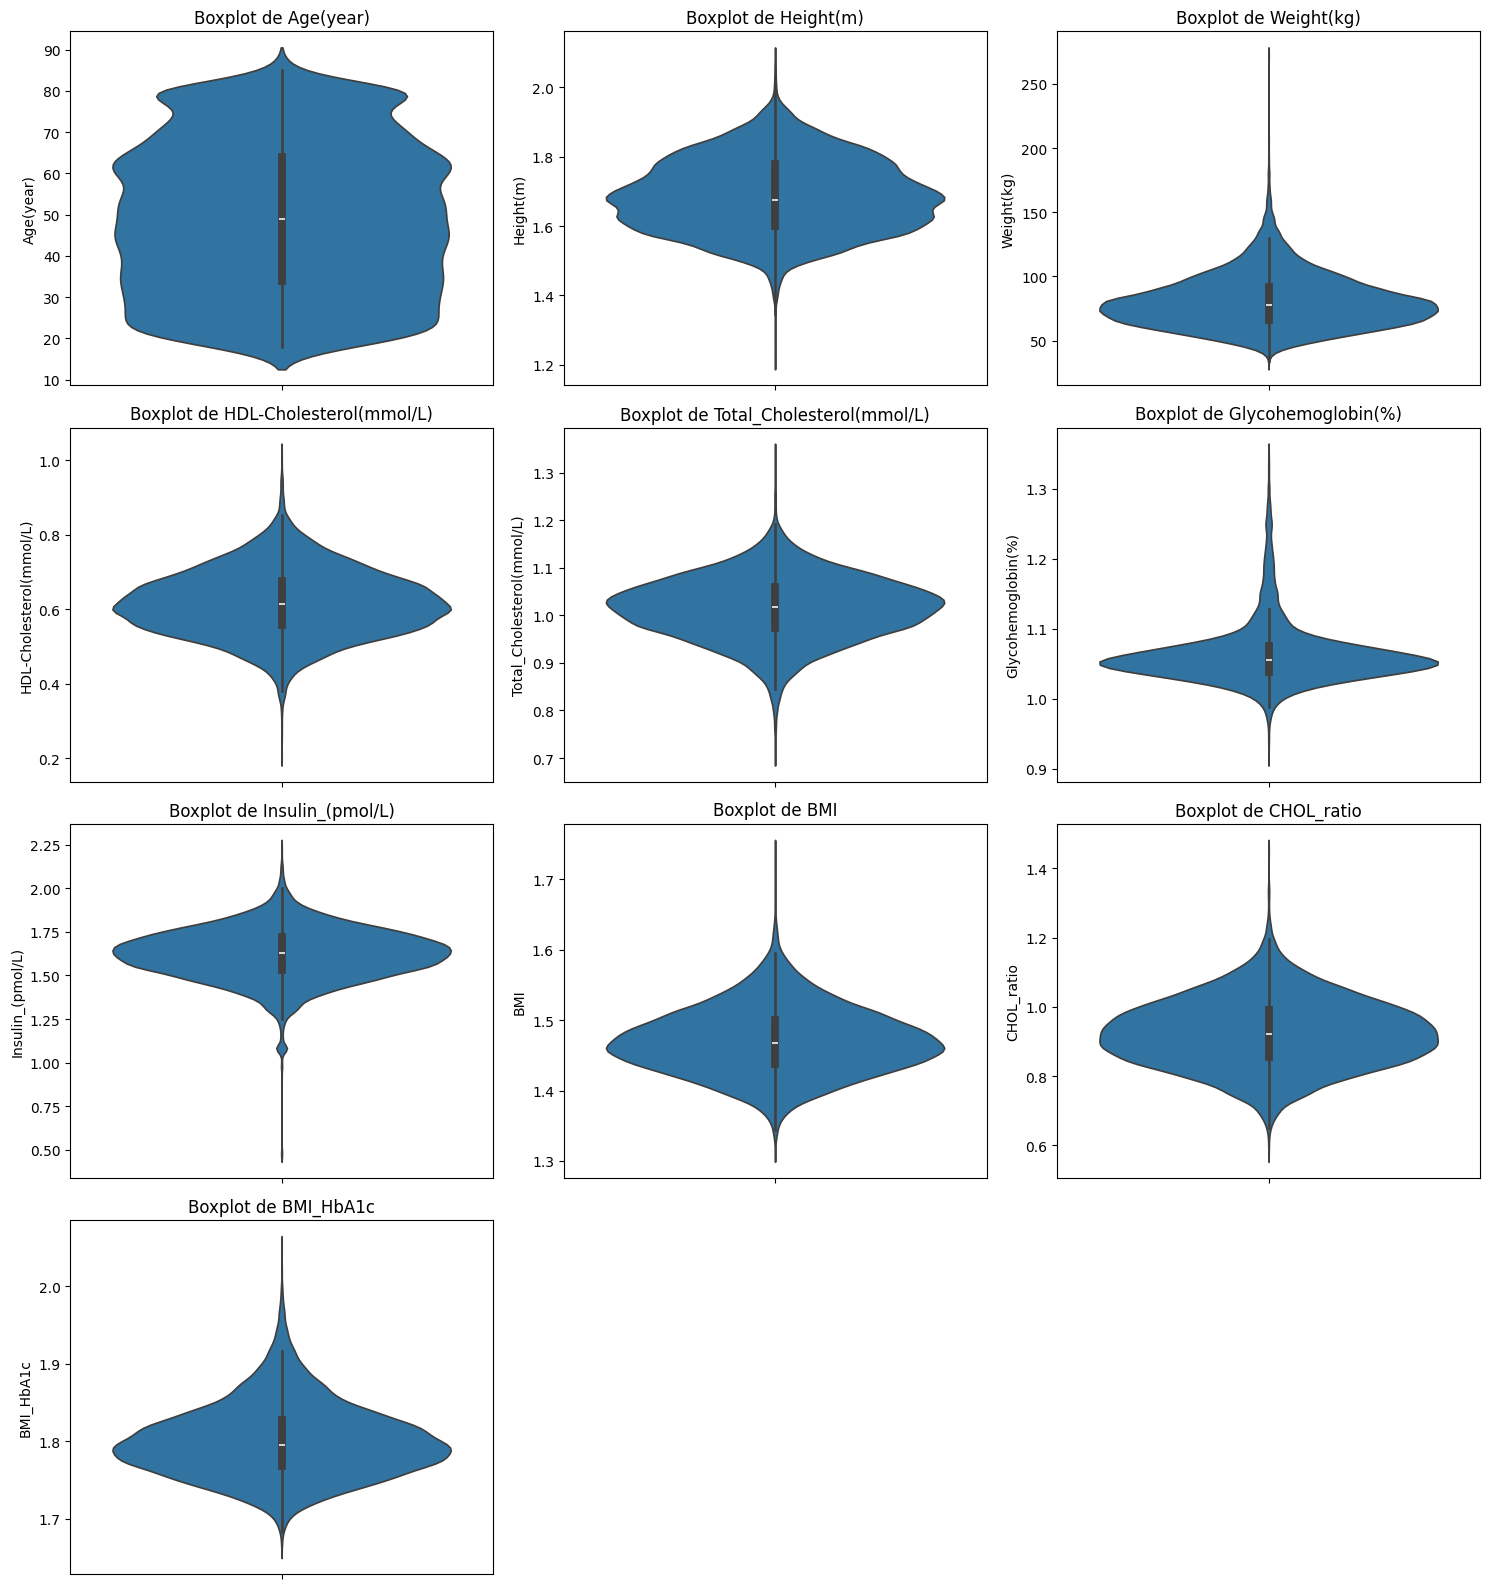

In [ ]:

# Obtener las columnas numéricas
num_cols = X_train[num_features].columns

# Definir el tamaño de la grilla (ejemplo: 3 filas x 3 columnas)
n_cols = 3  # Número de columnas en la cuadrícula
n_rows = int(np.ceil(len(num_cols) / n_cols))  # Calcula las filas necesarias

# Crear la figura con subgráficos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))

# Asegurar que 'axes' sea un array plano para iterar fácilmente
axes = axes.flatten()

# Iterar sobre cada variable y crear un boxplot en la posición correspondiente
for i, col in enumerate(num_cols):
    sns.violinplot(y=X_train[col], ax=axes[i])
    axes[i].set_title(f"Boxplot de {col}")

# Ocultar los ejes vacíos (si hay más subplots que columnas)
for i in range(len(num_cols), len(axes)):
    fig.delaxes(axes[i])  # Elimina los gráficos vacíos

plt.tight_layout()  # Ajusta el espacio entre gráficos
plt.show()

### Univariant analysis for categorical features

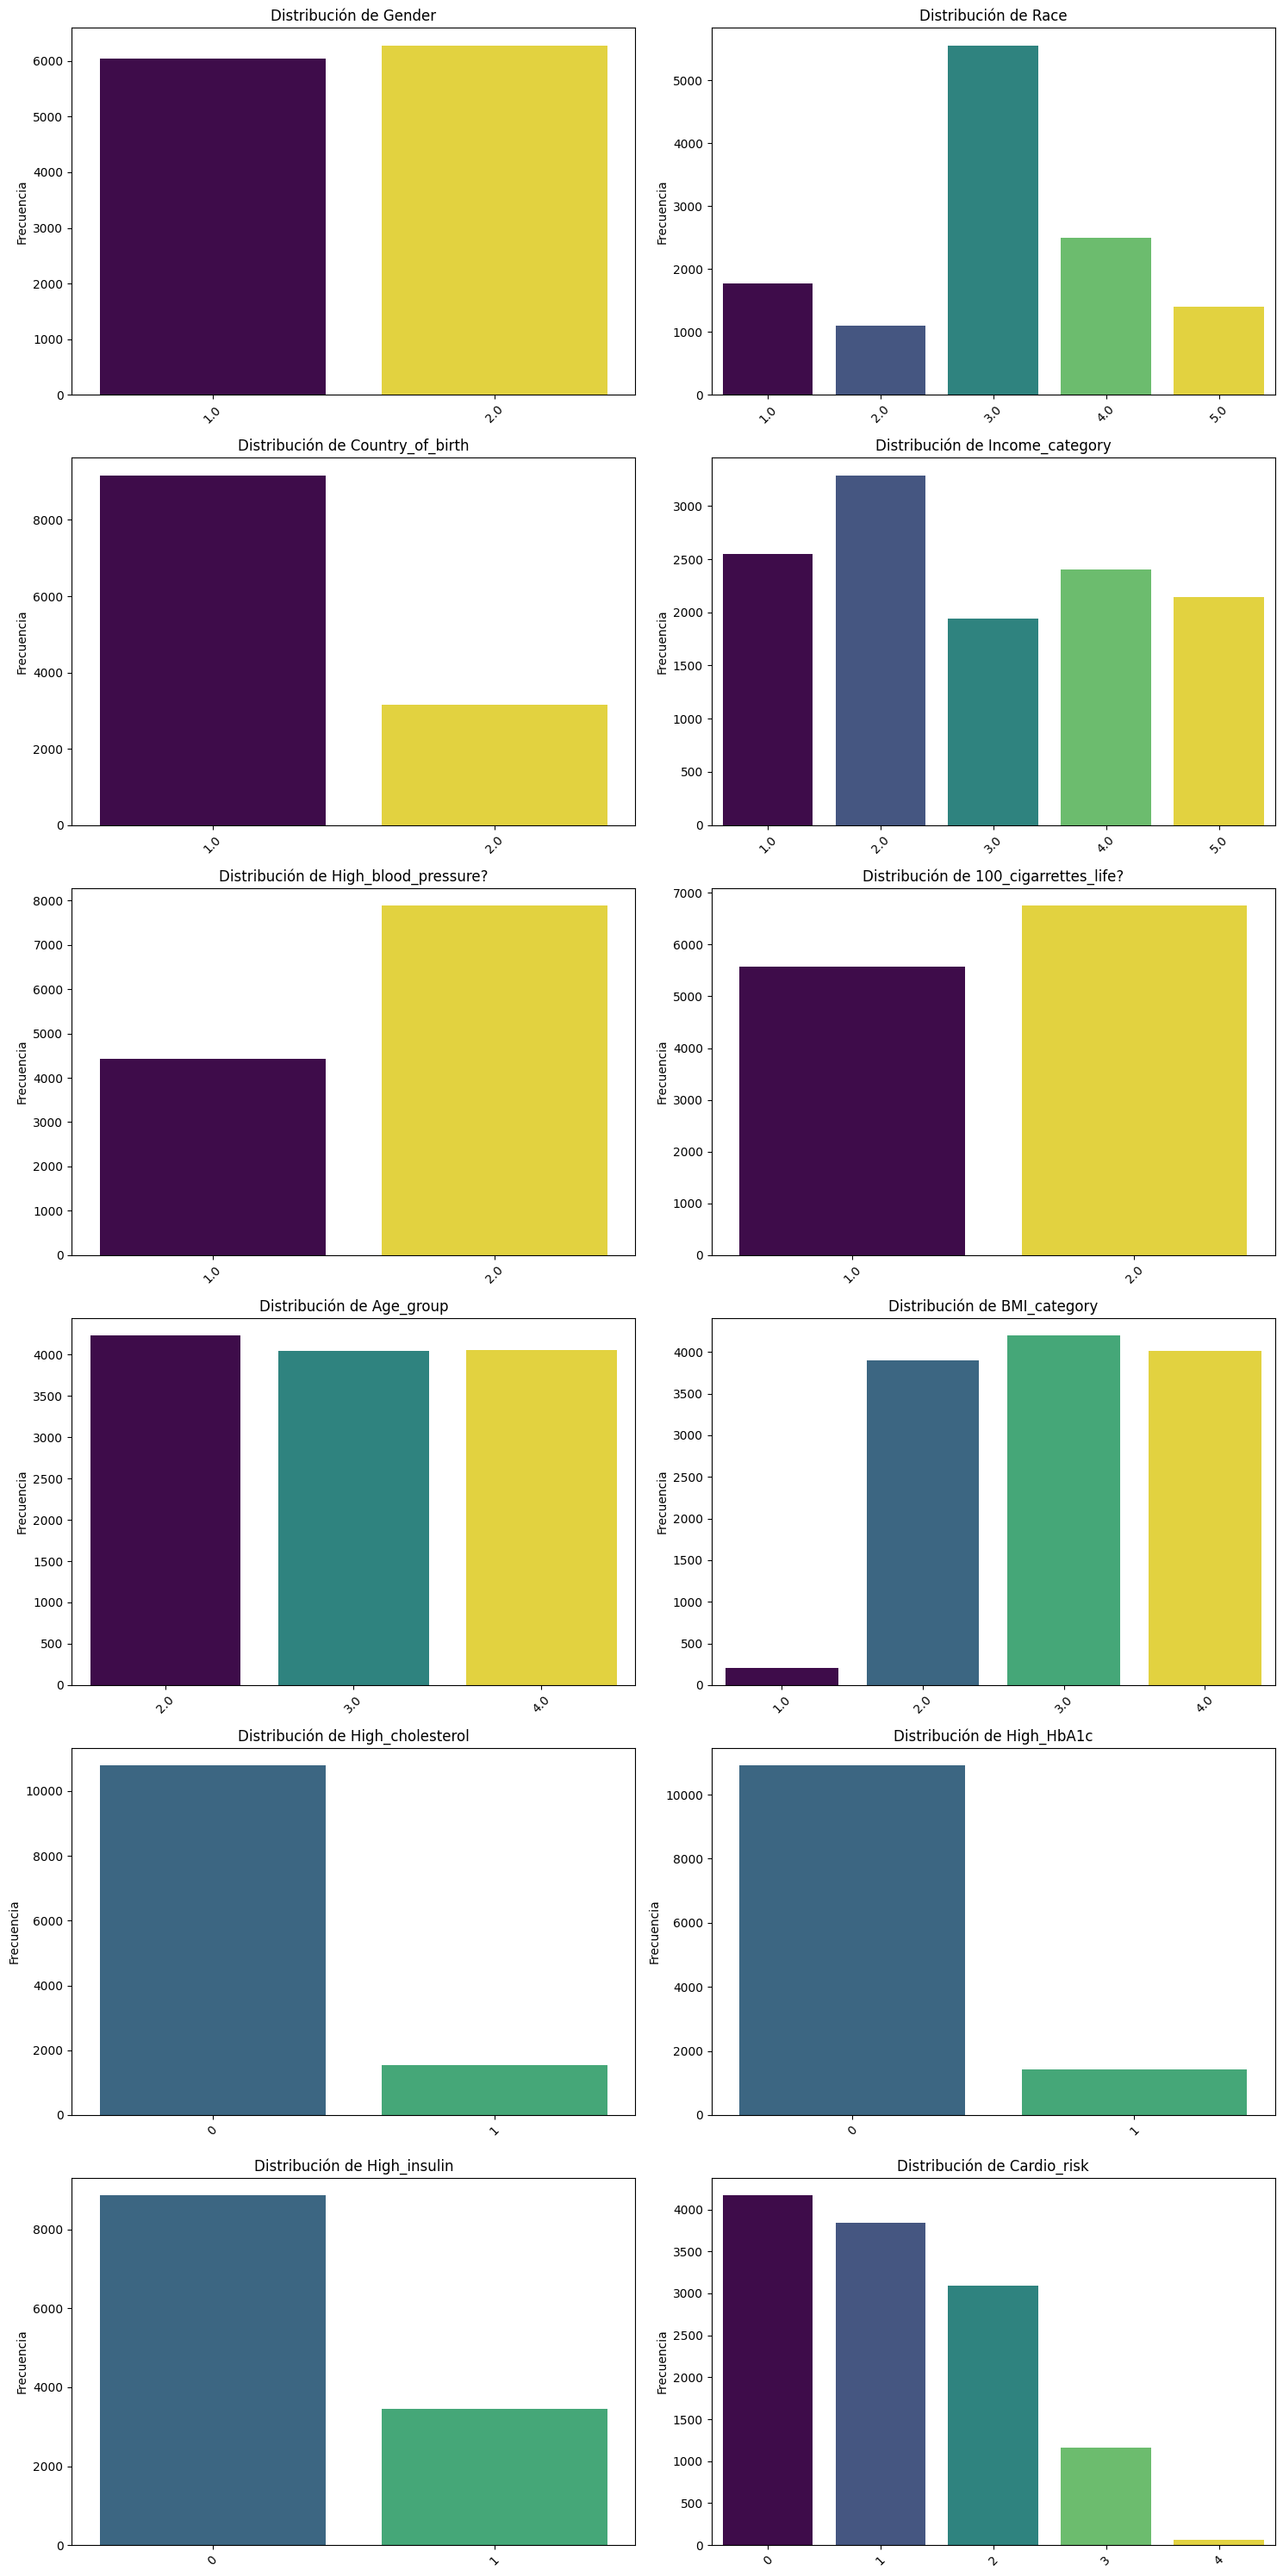

In [ ]:
tds.pinta_distribucion_categoricas(X_train, cat_features)

### Bivariant analysis

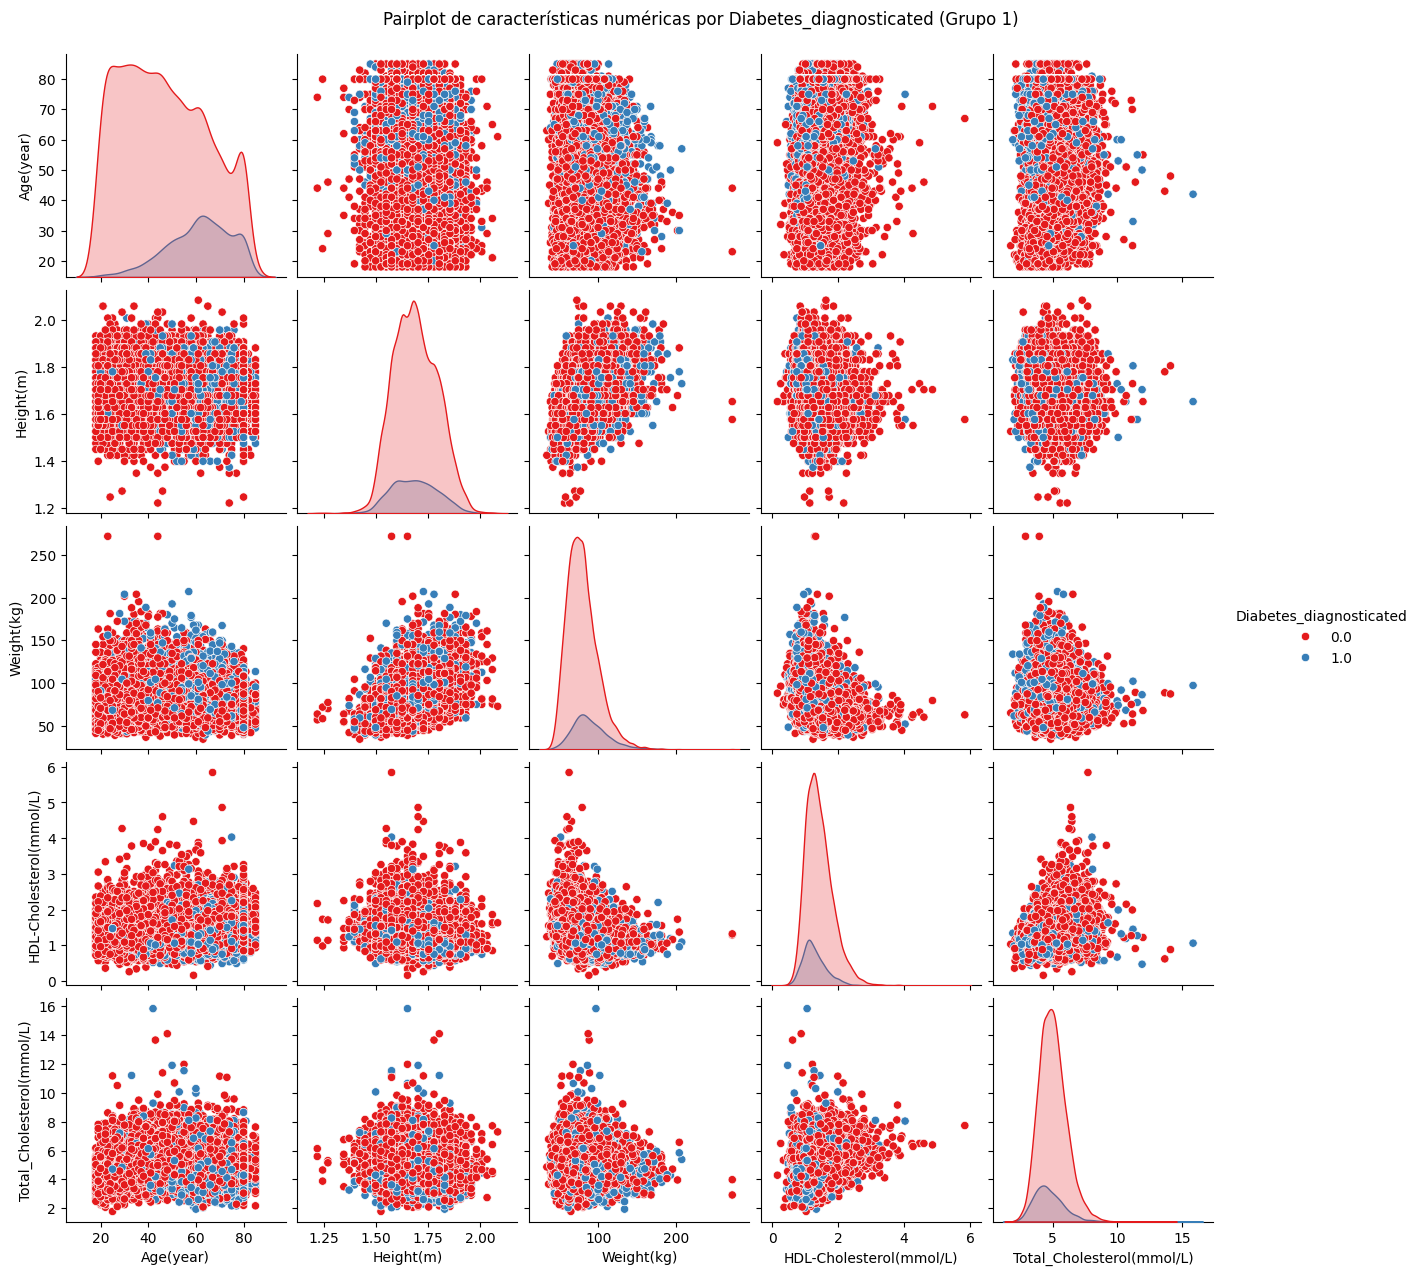

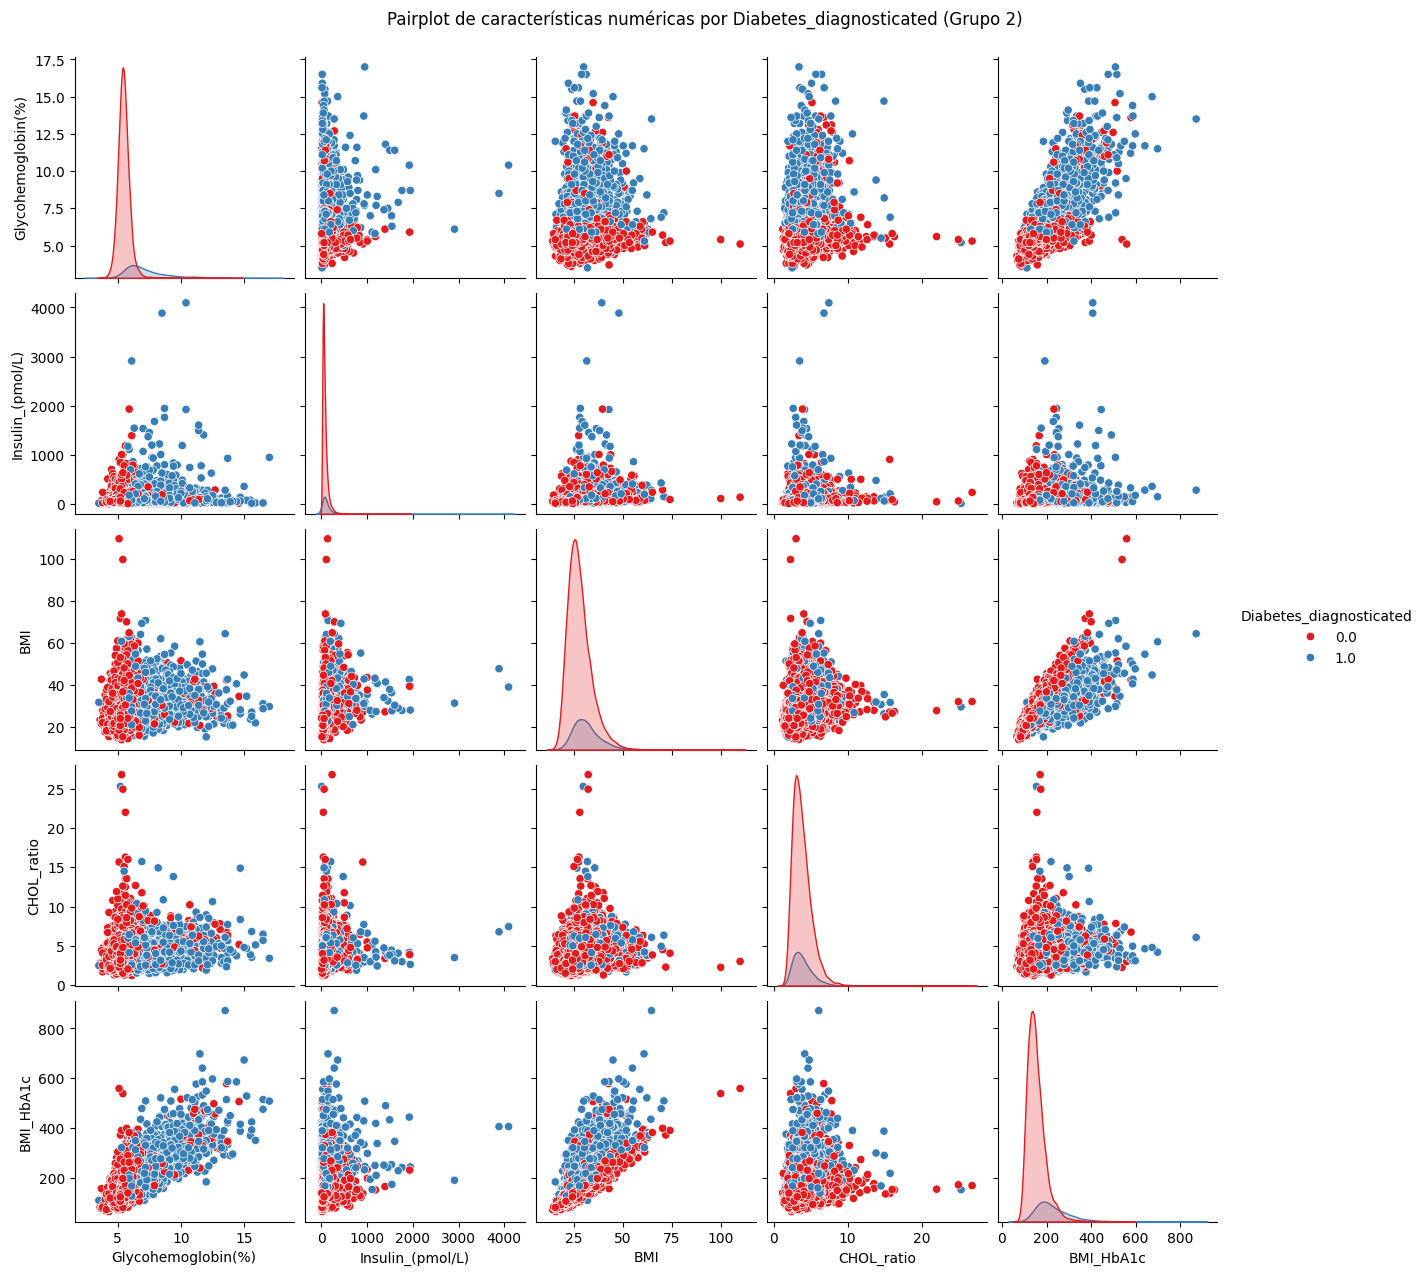

In [ ]:
tds.plot_pairplots_by_category(df, num_columns=num_features, cat_column=target)

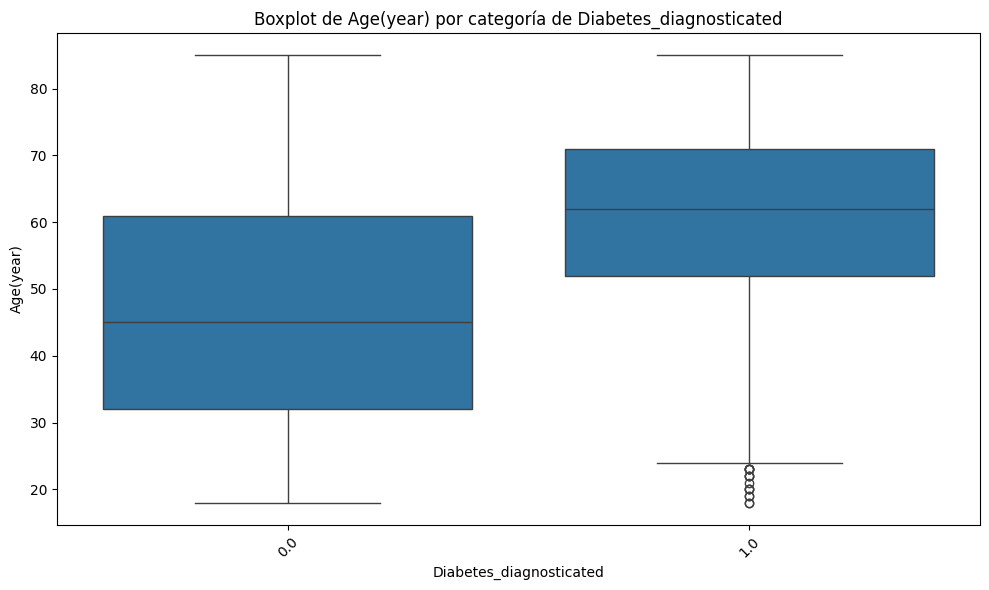

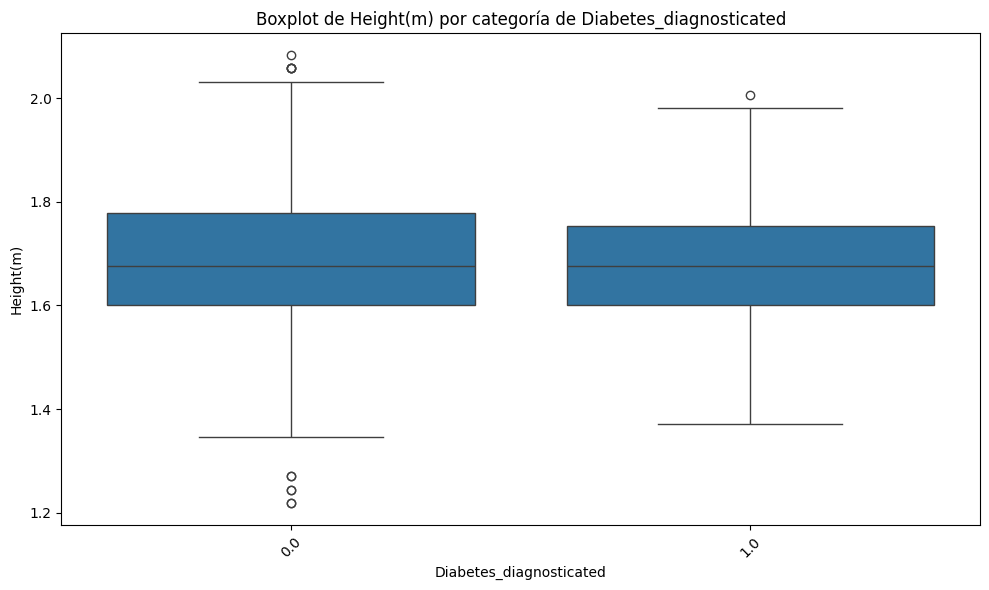

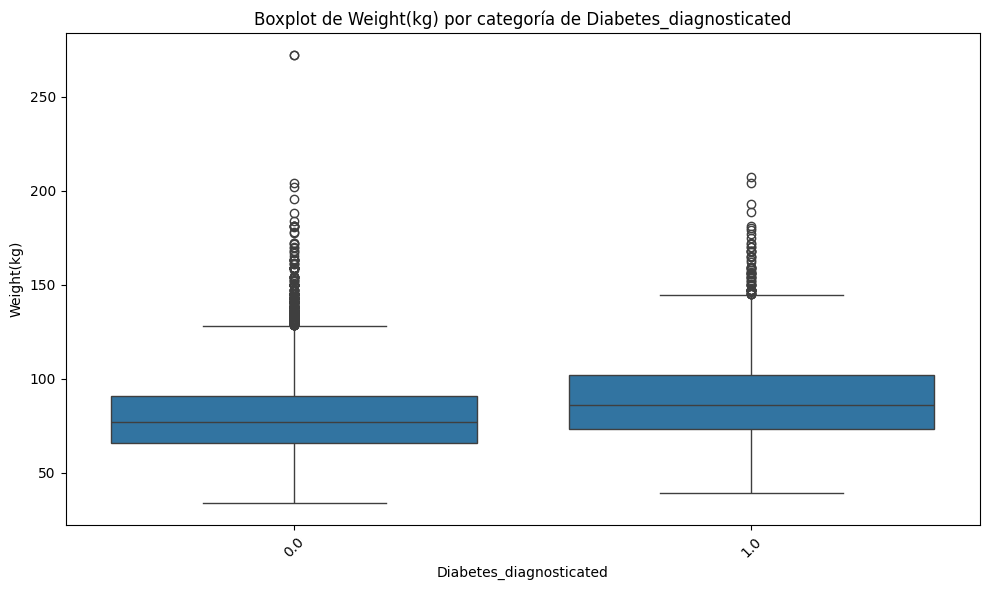

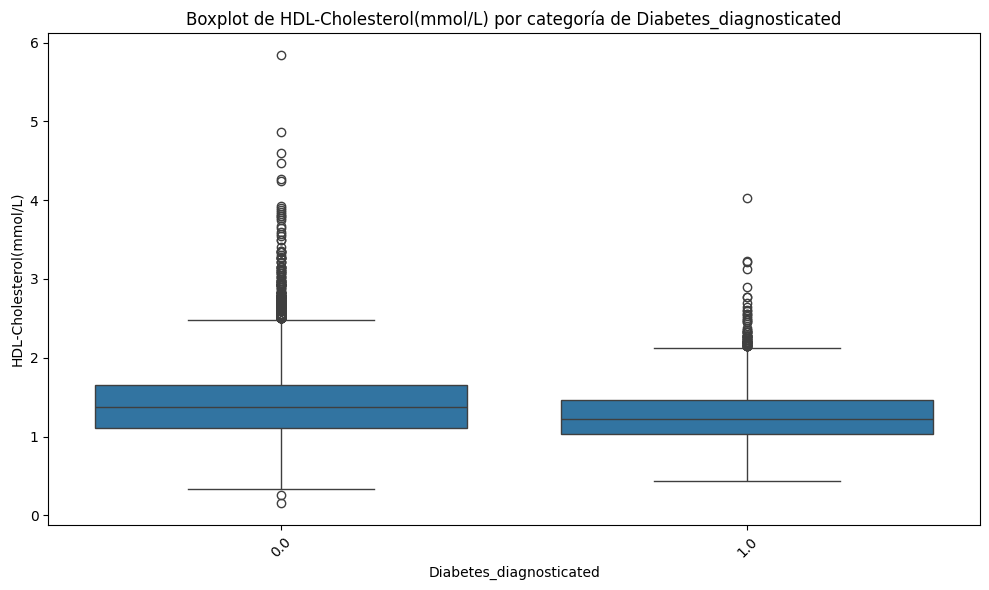

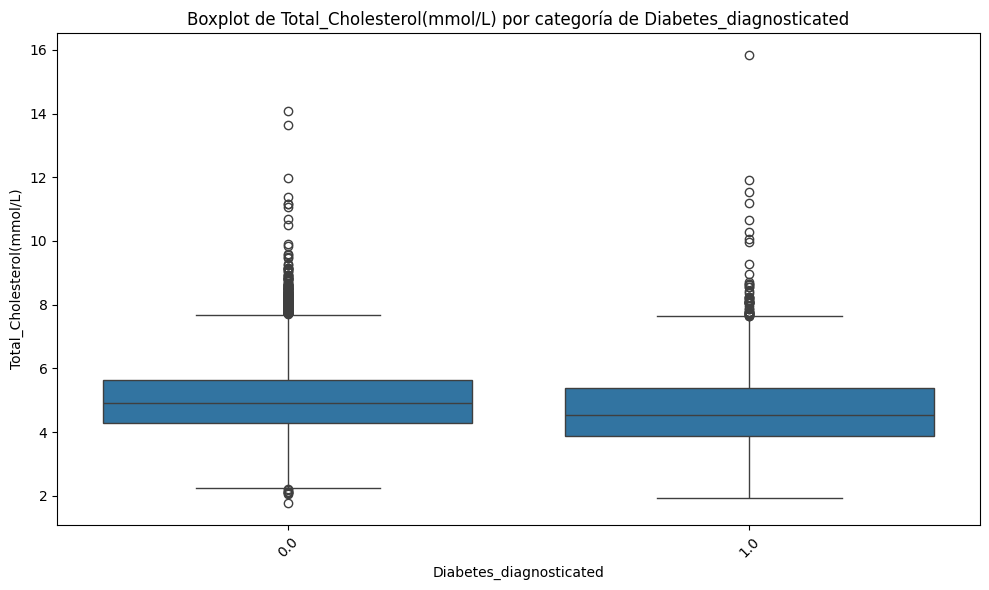

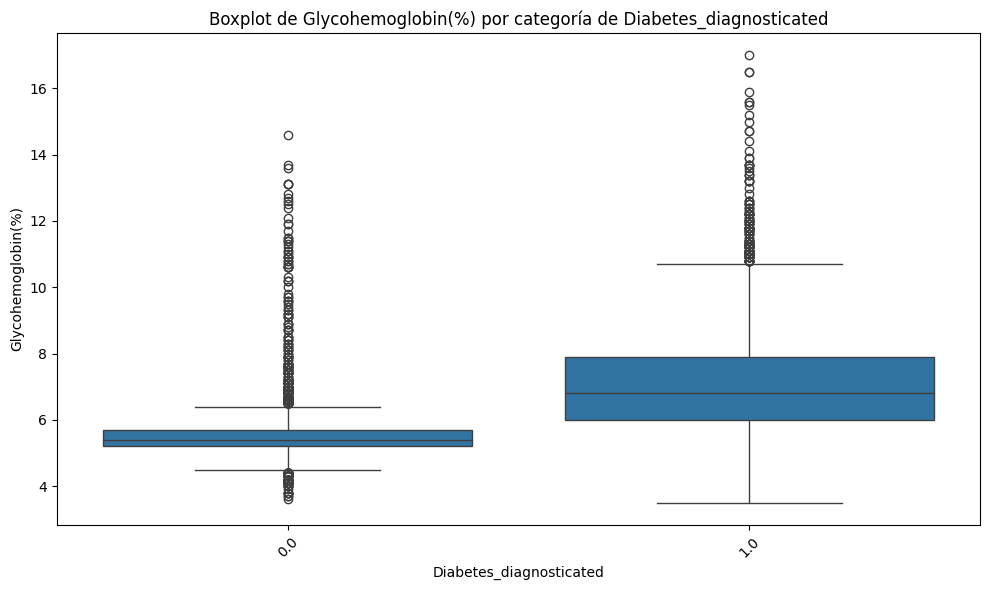

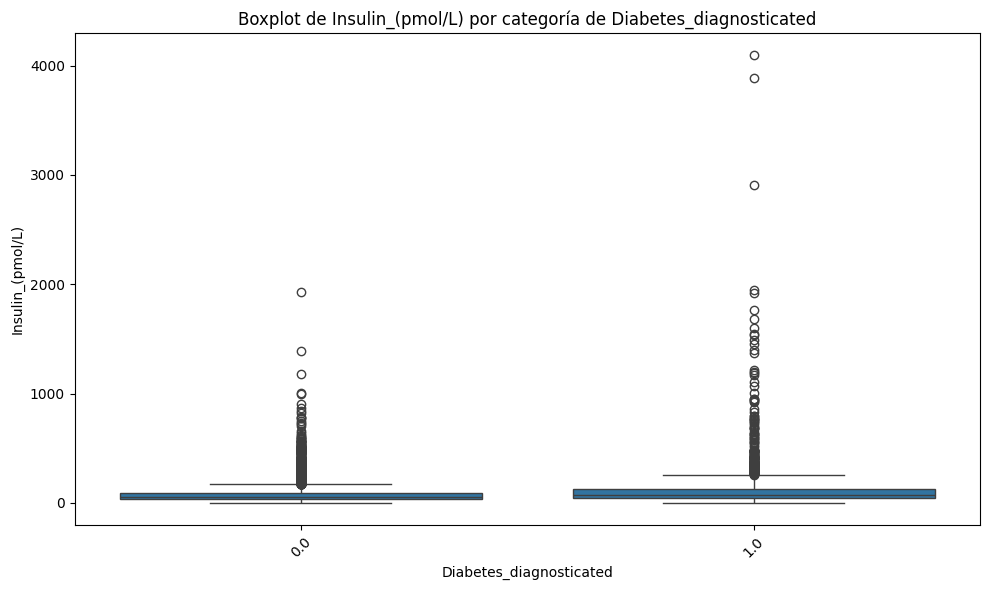

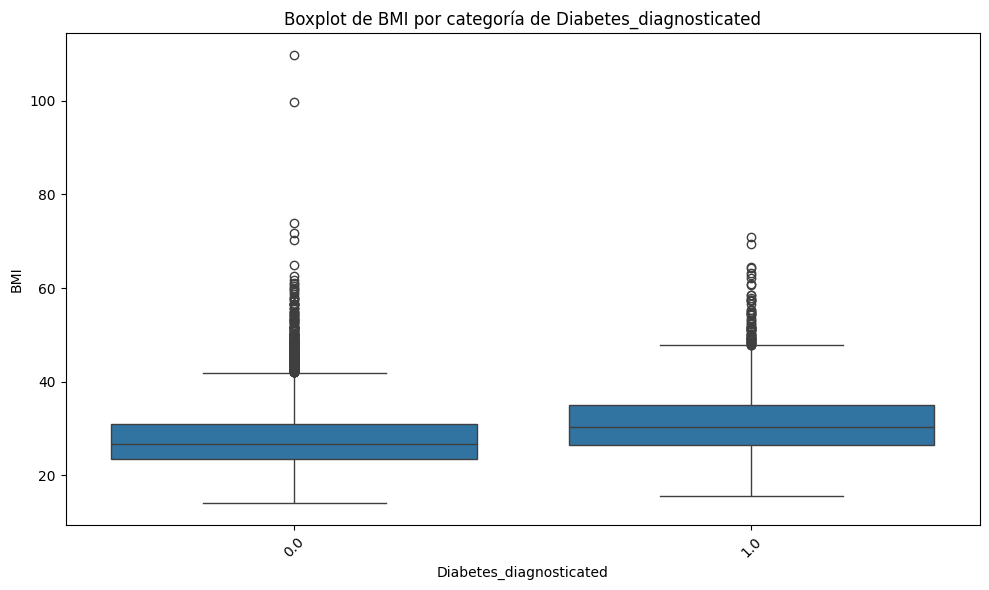

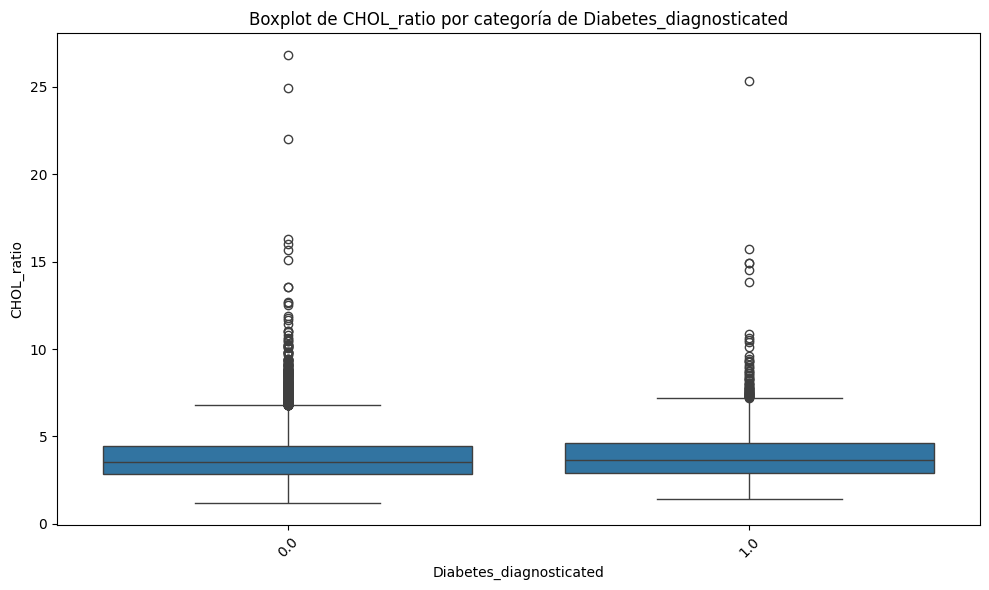

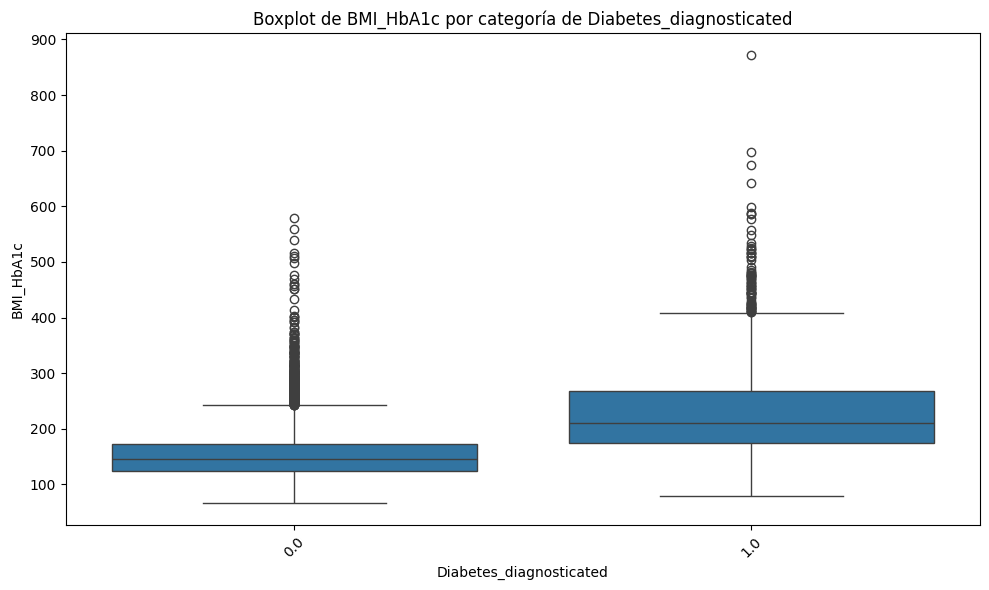

In [ ]:
tds.plot_boxplots_by_category(df, num_features, cat_column=target)

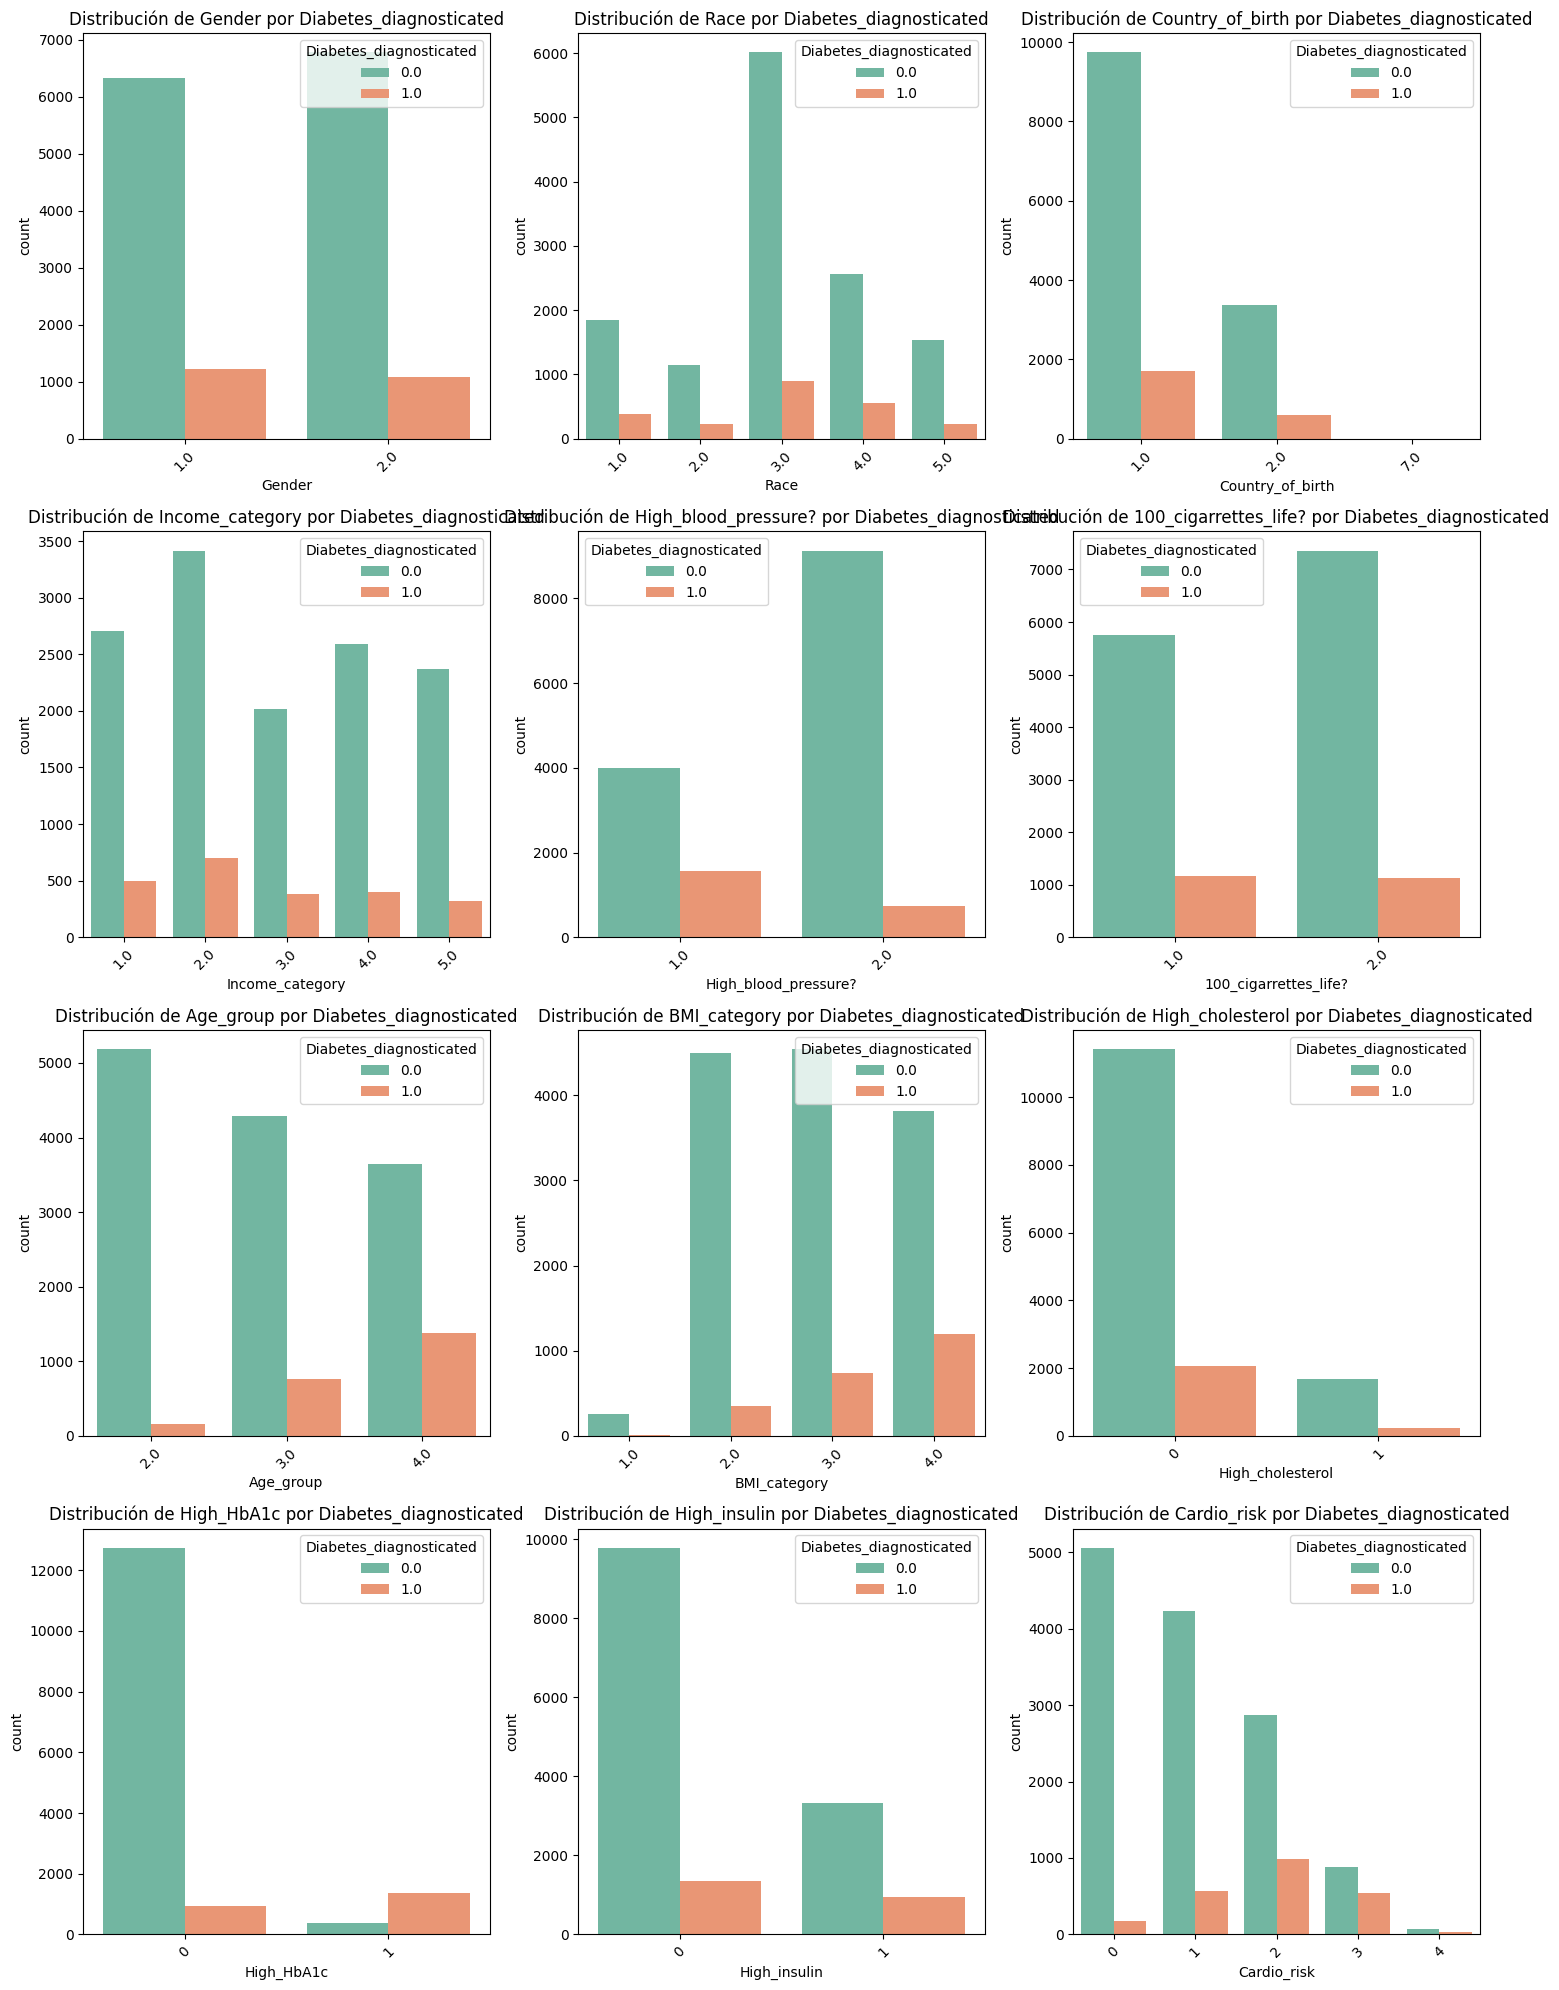

In [236]:
tds.plot_categorical_distribution_by_target(df, cat_features, target)

### MATRIX CORRELATION

interval columns not set, guessing: ['Gender', 'Age(year)', 'Race', 'Country_of_birth', 'Income_category', 'Height(m)', 'Weight(kg)', 'HDL-Cholesterol(mmol/L)', 'Total_Cholesterol(mmol/L)', 'Glycohemoglobin(%)', 'Insulin_(pmol/L)', 'High_blood_pressure?', '100_cigarrettes_life?', 'Diabetes_diagnosticated', 'BMI', 'CHOL_ratio', 'Age_group', 'BMI_category', 'High_cholesterol', 'High_HbA1c', 'BMI_HbA1c', 'High_insulin', 'Cardio_risk']


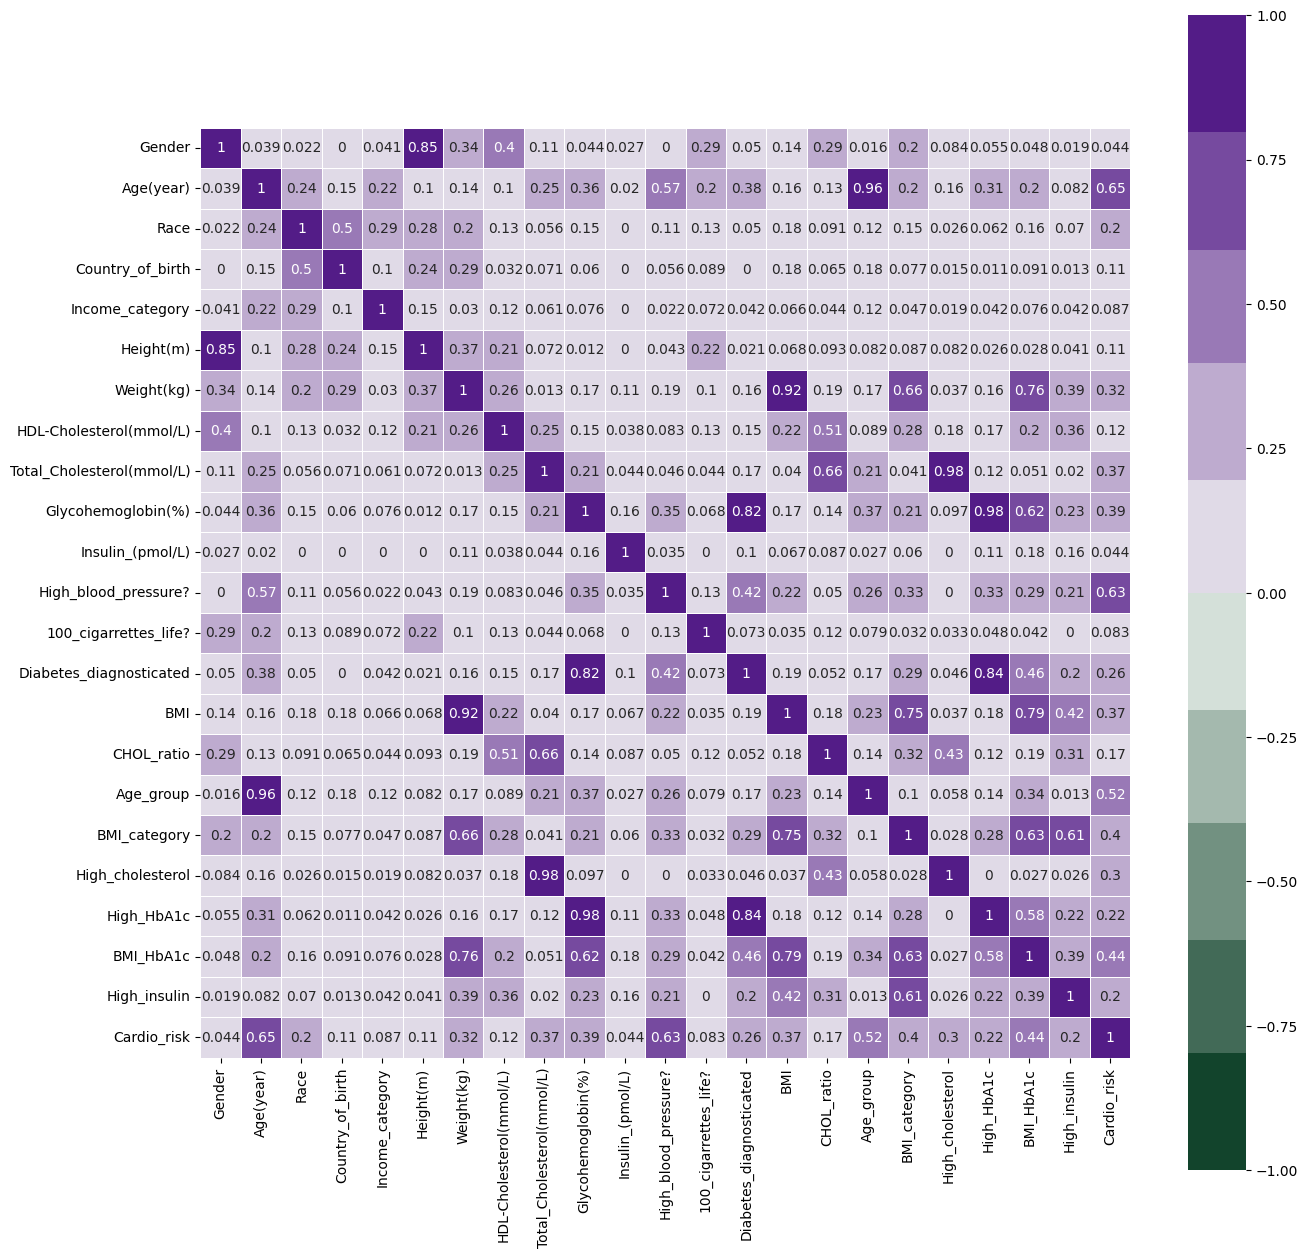

In [ ]:

phik_matrix = df.phik_matrix()

plt.figure(figsize=(15,15))
sns.heatmap(phik_matrix,
            vmin=-1,
            vmax=1,
            center=0,
            cmap=sns.diverging_palette(145, 280, s=85, l=25, n=10),
            square=True,
            annot=True,
            linewidths=.5);

### SCALING

In [237]:
# 3️⃣ Escalar las numéricas
scaler = StandardScaler()

X_train_scaled_numeric = pd.DataFrame(
    scaler.fit_transform(X_train[num_features]),
    columns=num_features,
    index=X_train.index
)

X_test_scaled_numeric = pd.DataFrame(
    scaler.transform(X_test[num_features]),
    columns=num_features,
    index=X_test.index
)

# 4️⃣ Recuperar y unir columnas no numéricas
X_train_final = pd.concat([X_train_scaled_numeric, X_train[cat_features]], axis=1)
X_test_final = pd.concat([X_test_scaled_numeric, X_test[cat_features]], axis=1)


In [ ]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12326 entries, 32958.0 to 65298.0
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age(year)                  12326 non-null  float64
 1   Height(m)                  12326 non-null  float64
 2   Weight(kg)                 12326 non-null  float64
 3   HDL-Cholesterol(mmol/L)    12326 non-null  float64
 4   Total_Cholesterol(mmol/L)  12326 non-null  float64
 5   Glycohemoglobin(%)         12326 non-null  float64
 6   Insulin_(pmol/L)           12326 non-null  float64
 7   BMI                        12326 non-null  float64
 8   CHOL_ratio                 12326 non-null  float64
 9   BMI_HbA1c                  12326 non-null  float64
 10  Gender                     12326 non-null  float64
 11  Race                       12326 non-null  float64
 12  Country_of_birth           12326 non-null  float64
 13  Income_category            12326 non-null  

###  Model evaluation

We are going to try different scoring methods due to we have an imbalance in our target class. Then we are going to use the following metrics:
- F1
- Recall
- average_precision

The best three models captured are going to be evaluated their hiperparameters.

Evaluando modelo: Logistic Regression con métrica recall...
Evaluando modelo: SVC con métrica recall...
Evaluando modelo: Decision Tree con métrica recall...
Evaluando modelo: Random Forest con métrica recall...
Evaluando modelo: KNN con métrica recall...
Evaluando modelo: Gradient Boosting con métrica recall...
Evaluando modelo: AdaBoost con métrica recall...
Evaluando modelo: XGBoost con métrica recall...
Evaluando modelo: LightGBM con métrica recall...
Evaluando modelo: CatBoost con métrica recall...

El modelo ganador es: Gradient Boosting con una recall media de 0.6363

                Modelo  Recall Media
5    Gradient Boosting      0.636314
9             CatBoost      0.628184
8             LightGBM      0.627642
3        Random Forest      0.626016
6             AdaBoost      0.624932
7              XGBoost      0.624390
2        Decision Tree      0.613008
1                  SVC      0.606504
0  Logistic Regression      0.590244
4                  KNN      0.514905


c:\Users\rodri\Git_Repositories\Project_Break_II\src\utils\Toolbox_datascience.py:861: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f"{scoring.capitalize()} Media", y="Modelo", data=resultados_df, palette="viridis")


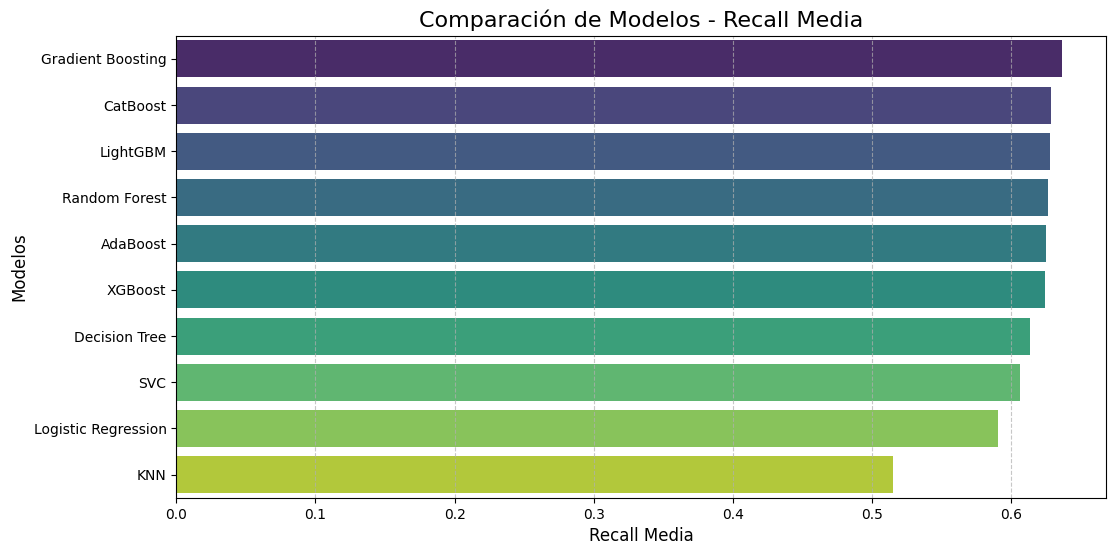

In [ ]:
recall_models = tds.evaluar_modelos_clasificacion(X_train_final, y_train, scoring="recall")

Evaluando modelo: Logistic Regression con métrica f1...
Evaluando modelo: SVC con métrica f1...
Evaluando modelo: Decision Tree con métrica f1...
Evaluando modelo: Random Forest con métrica f1...
Evaluando modelo: KNN con métrica f1...
Evaluando modelo: Gradient Boosting con métrica f1...
Evaluando modelo: AdaBoost con métrica f1...
Evaluando modelo: XGBoost con métrica f1...
Evaluando modelo: LightGBM con métrica f1...
Evaluando modelo: CatBoost con métrica f1...

El modelo ganador es: Gradient Boosting con una f1 media de 0.7037

                Modelo  F1 Media
5    Gradient Boosting  0.703741
3        Random Forest  0.701099
8             LightGBM  0.699034
9             CatBoost  0.698335
6             AdaBoost  0.690062
1                  SVC  0.686921
7              XGBoost  0.685437
0  Logistic Regression  0.682991
4                  KNN  0.613171
2        Decision Tree  0.596553


c:\Users\rodri\Git_Repositories\Project_Break_II\src\utils\Toolbox_datascience.py:861: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f"{scoring.capitalize()} Media", y="Modelo", data=resultados_df, palette="viridis")


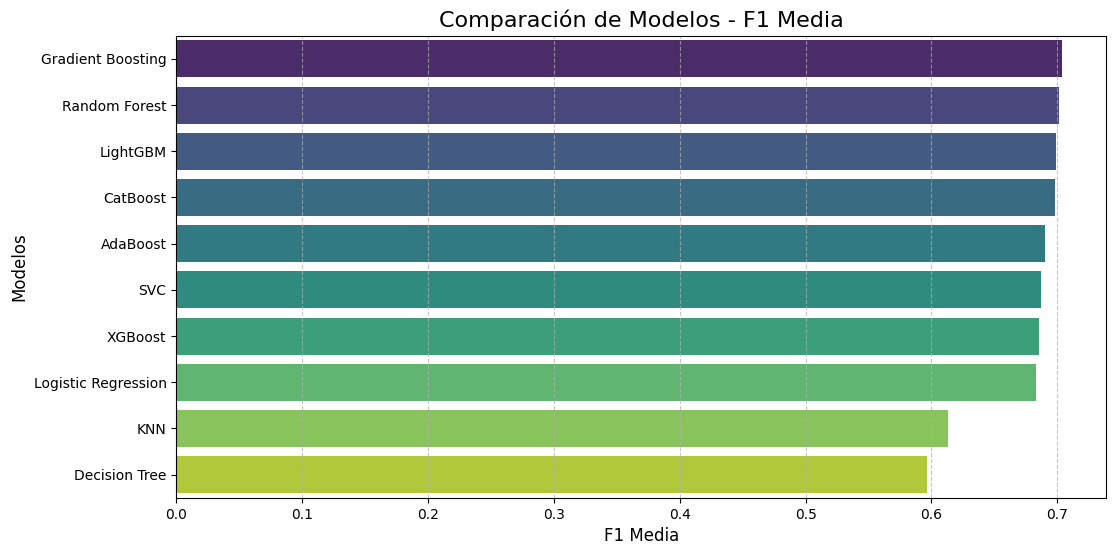

In [ ]:
f1_models = tds.evaluar_modelos_clasificacion(X_train_final, y_train, scoring="f1")

Evaluando modelo: Logistic Regression con métrica average_precision...
Evaluando modelo: SVC con métrica average_precision...
Evaluando modelo: Decision Tree con métrica average_precision...
Evaluando modelo: Random Forest con métrica average_precision...
Evaluando modelo: KNN con métrica average_precision...
Evaluando modelo: Gradient Boosting con métrica average_precision...
Evaluando modelo: AdaBoost con métrica average_precision...
Evaluando modelo: XGBoost con métrica average_precision...
Evaluando modelo: LightGBM con métrica average_precision...
Evaluando modelo: CatBoost con métrica average_precision...

El modelo ganador es: Gradient Boosting con una average_precision media de 0.7719

                Modelo  Average_precision Media
5    Gradient Boosting                 0.771859
9             CatBoost                 0.771633
8             LightGBM                 0.762719
3        Random Forest                 0.758255
1                  SVC                 0.751056
0  Logist

c:\Users\rodri\Git_Repositories\Project_Break_II\src\utils\Toolbox_datascience.py:861: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f"{scoring.capitalize()} Media", y="Modelo", data=resultados_df, palette="viridis")


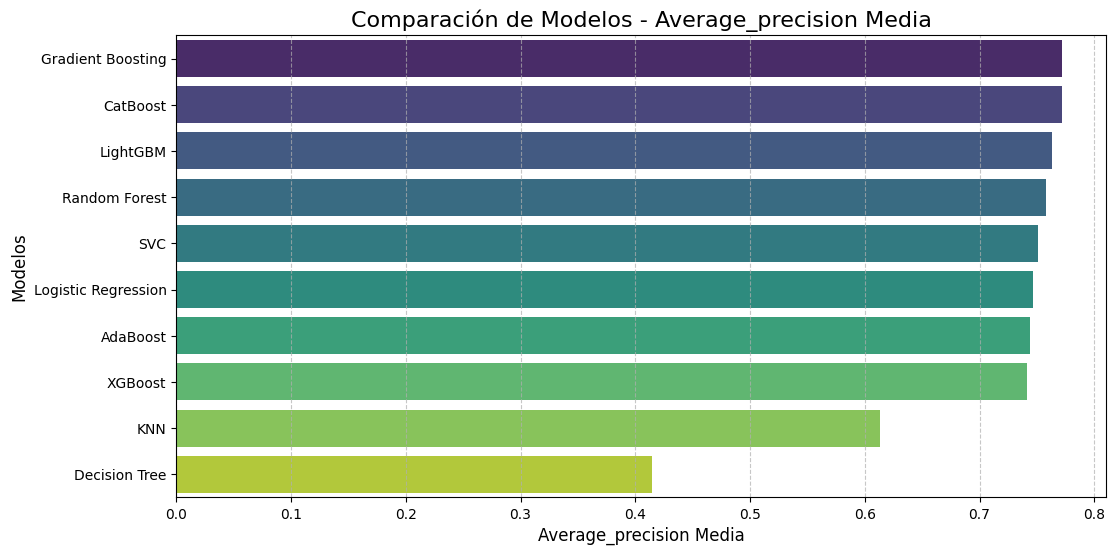

In [ ]:
average_precision_models = tds.evaluar_modelos_clasificacion(X_train_final, y_train, scoring="average_precision")

### Hiperparameter evaluation top-3 models

In [ ]:
# Ordenar por 'Accuracy Media' en orden descendente y seleccionar los 3 mejores
best_recall = recall_models.sort_values(by="Recall Media", ascending=False).head(1).rename(columns={"Recall Media": "Scoring"})
best_f1 = f1_models.sort_values(by="F1 Media", ascending=False).head(1).rename(columns={"F1 Media": "Scoring"})
best_average_precision = average_precision_models.sort_values(by="Average_precision Media", ascending=False).head(1).rename(columns={"Average_precision Media": "Scoring"})

best_3models = pd.concat([best_recall, best_f1, best_average_precision])
# Mostrar los mejores modelos
print(best_3models)


              Modelo   Scoring
5  Gradient Boosting  0.636314
5  Gradient Boosting  0.703741
5  Gradient Boosting  0.771859


In [288]:
param_grid_gb = {
    'n_estimators': np.arange(50, 300, 25),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]  # <- corregido aquí
}

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

param_grid_lgb = {
    'n_estimators': np.arange(50, 150, 25),             # Menos árboles
    'learning_rate': np.linspace(0.03, 0.1, 4),         # No tan bajo como 0.01, ni tan alto como 0.3
    'num_leaves': [20, 31, 40],                         # Más pequeños
    'max_depth': [4, 5, 6],                             # Menor profundidad
    'subsample': [0.7, 0.8],                            # Regularización por filas
    'colsample_bytree': [0.6, 0.8],                     # Regularización por columnas
    'reg_alpha': [0.0, 0.1],                            # L1 regularization
    'reg_lambda': [0.0, 0.1],                           # L2 regularization
    'scale_pos_weight': [scale_pos_weight]             # Para clases desbalanceadas
}


param_grid_cat = {
    'iterations': np.arange(300, 600, 50),
    'learning_rate': np.linspace(0.01, 0.1, 6),
    'depth': [4, 6, 8],
    'l2_leaf_reg': [3, 5, 7],
    'border_count': [32, 64],
    'bagging_temperature': [0.0, 0.3, 0.5]
}



gb_model = GradientBoostingClassifier(random_state=42)
search_gb = RandomizedSearchCV(
    gb_model,
    param_distributions=param_grid_gb,
    n_iter=30,
    cv=5,
    scoring='f1',  
    n_jobs=-1,
    random_state=42
)

search_gb.fit(X_train_final, y_train)

print("Mejor modelo Gradient Boosting:")
print(search_gb.best_params_)
print(classification_report(y_test, search_gb.predict(X_test_final)))

lgb_model = LGBMClassifier(random_state=42)
search_lgb = RandomizedSearchCV(
    lgb_model,
    param_distributions=param_grid_lgb,
    n_iter=40,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
search_lgb.fit(X_train_final, y_train)

print("Mejor modelo LightGBM:")
print(search_lgb.best_params_)
print(classification_report(y_test, search_lgb.predict(X_test_final)))


cat_model = CatBoostClassifier(
    verbose=0,
    random_state=42,
    scale_pos_weight=scale_pos_weight
)
search_cat = RandomizedSearchCV(
    cat_model,
    param_distributions=param_grid_cat,
    n_iter=40,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
search_cat.fit(X_train, y_train)

print("Mejor modelo CatBoost:")
print(search_cat.best_params_)
print(classification_report(y_test, search_cat.predict(X_test_final)))




Mejor modelo Gradient Boosting:
{'subsample': 0.8, 'n_estimators': 175, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 4, 'learning_rate': 0.042222222222222223}
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      2629
         1.0       0.76      0.59      0.66       453

    accuracy                           0.91      3082
   macro avg       0.85      0.78      0.81      3082
weighted avg       0.91      0.91      0.91      3082

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[LightGBM] [Info] Number of positive: 1845, number of negative: 10481
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1871
[LightGBM] [Info] Number of data points in the train set: 12326, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.1496

### Evaluate best optimized models

In [289]:
# Supongamos que usaste train_test_split antes
y_pred = search_lgb.predict(X_test_final)
y_prob = search_lgb.predict_proba(X_test_final)[:, 1]  # Probabilidades para ROC/AUC



In [290]:

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall (Sensibilidad):", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_prob))

# Reporte completo
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8935756002595717
Precision: 0.6181474480151229
Recall (Sensibilidad): 0.7218543046357616
F1 Score: 0.6659877800407332
AUC-ROC: 0.9093423917470026

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.92      0.94      2629
         1.0       0.62      0.72      0.67       453

    accuracy                           0.89      3082
   macro avg       0.78      0.82      0.80      3082
weighted avg       0.90      0.89      0.90      3082



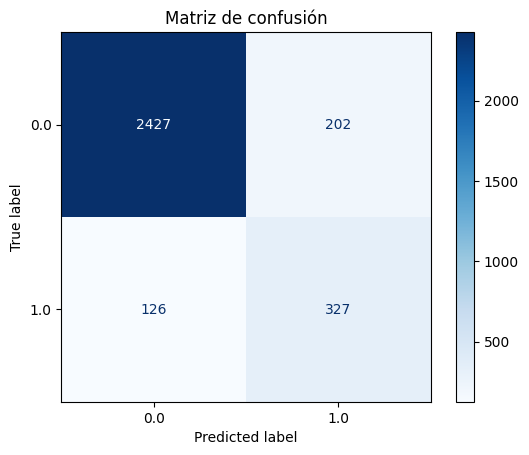

In [291]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_search.classes_)
disp.plot(cmap='Blues')
plt.title("Matriz de confusión")
plt.show()


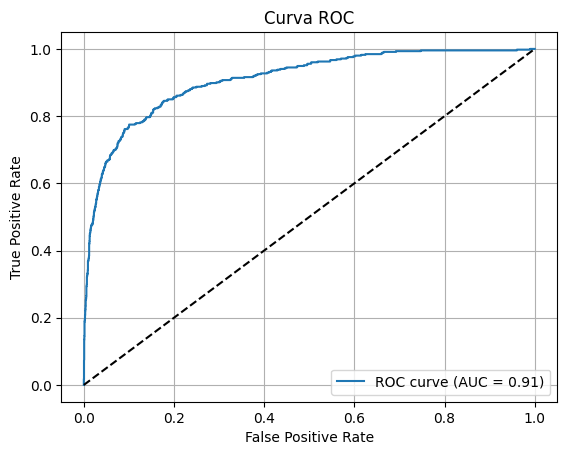

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc_score(y_test, y_prob))
plt.plot([0, 1], [0, 1], 'k--')  # línea diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()


# Model evaluation descarting unimportant features

In [293]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12326 entries, 32958.0 to 65298.0
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age(year)                  12326 non-null  float64
 1   Height(m)                  12326 non-null  float64
 2   Weight(kg)                 12326 non-null  float64
 3   HDL-Cholesterol(mmol/L)    12326 non-null  float64
 4   Total_Cholesterol(mmol/L)  12326 non-null  float64
 5   Glycohemoglobin(%)         12326 non-null  float64
 6   Insulin_(pmol/L)           12326 non-null  float64
 7   BMI                        12326 non-null  float64
 8   CHOL_ratio                 12326 non-null  float64
 9   BMI_HbA1c                  12326 non-null  float64
 10  Gender                     12326 non-null  float64
 11  Race                       12326 non-null  float64
 12  Country_of_birth           12326 non-null  float64
 13  Income_category            12326 non-null  

In [245]:
X_train_selected = X_train_final.drop(columns=["Country_of_birth", "Gender", "Race", "100_cigarrettes_life?", "High_cholesterol"])
X_test_selected = X_test_final.drop(columns=["Country_of_birth", "Gender", "Race", "100_cigarrettes_life?", "High_cholesterol"])
X_train_selected

Age(year)  Height(m)  Weight(kg)  HDL-Cholesterol(mmol/L)  \
SEQN                                                                 
32958.0  -0.230035  -0.597224   -0.663016                 1.296391   
81548.0   1.093814   1.097163    0.925759                 0.850535   
97735.0  -1.057440   0.855108    1.121635                -0.756645   
71244.0   0.818012  -0.355169   -0.684780                 0.694259   
37573.0  -1.498723   0.855108    0.751647                -0.756645   
...            ...        ...         ...                      ...   
56047.0  -1.222921  -0.113114   -0.728308                 1.088194   
94050.0   0.321569   0.613052   -0.140679                -0.931889   
56872.0  -1.002280  -1.565446   -0.249499                -0.000240   
35818.0   1.976380  -0.113114    0.425186                -0.756645   
65298.0  -0.009393   1.339219    0.076962                -0.076882   

         Total_Cholesterol(mmol/L)  Glycohemoglobin(%)  Insulin_(pmol/L)  \
SEQN                                                                       
32958.0                  -0.661306           -0.201607         -1.344241   
81548.0                   0.034116            1.619152          1.452049   
97735.0                  -1.033717           -0.434385          0.002294   
71244.0                  -0.165431           -0.434385         -0.835747   
37573.0                   1.061064           -0.317086         -0.159894   
...                            ...                 ...               ...   
56047.0                  -0.069504           -0.553560         -0.375237   
94050.0                   1.703288           -0.087890          1.105682   
56872.0                  -0.136476            0.024116          0.727109   
35818.0                   1.243788            0.456022         -0.027007   
65298.0                  -1.183055           -0.797788         -0.809067   

              BMI  CHOL_ratio  BMI_HbA1c  Income_category  \
SEQN                                                        
32958.0 -0.395320   -1.502120  -0.390847              5.0   
81548.0  0.503594   -0.749442   1.231364              3.0   
97735.0  0.822418   -0.084245   0.373275              2.0   
71244.0 -0.570265   -0.756961  -0.645167              5.0   
37573.0  0.463949    1.391202   0.175526              1.0   
...           ...         ...        ...              ...   
56047.0 -0.774722   -0.991772  -0.860129              4.0   
94050.0 -0.396083    2.038335  -0.330147              2.0   
56872.0  0.767351   -0.166773   0.580899              3.0   
35818.0  0.672316    1.520279   0.742602              2.0   
65298.0 -0.528546   -0.801636  -0.812482              4.0   

         High_blood_pressure?  Age_group  BMI_category  High_HbA1c  \
SEQN                                                                 
32958.0                   2.0        3.0           3.0           0   
81548.0                   1.0        4.0           4.0           1   
97735.0                   2.0        2.0           4.0           0   
71244.0                   2.0        4.0           2.0           0   
37573.0                   2.0        2.0           4.0           0   
...                       ...        ...           ...         ...   
56047.0                   2.0        2.0           2.0           0   
94050.0                   1.0        3.0           3.0           0   
56872.0                   2.0        2.0           4.0           0   
35818.0                   1.0        4.0           4.0           0   
65298.0                   1.0        3.0           2.0           0   

         High_insulin  Cardio_risk  
SEQN                                
32958.0             0            0  
81548.0             1            3  
97735.0             0            1  
71244.0             0            1  
37573.0             0            1  
...               ...          ...  
56047.0             0            0  
94050.0             1            2  
56872.0             1            1

Evaluando modelo: Logistic Regression con métrica average_precision...
Evaluando modelo: SVC con métrica average_precision...
Evaluando modelo: Decision Tree con métrica average_precision...
Evaluando modelo: Random Forest con métrica average_precision...
Evaluando modelo: KNN con métrica average_precision...
Evaluando modelo: Gradient Boosting con métrica average_precision...
Evaluando modelo: AdaBoost con métrica average_precision...
Evaluando modelo: XGBoost con métrica average_precision...
Evaluando modelo: LightGBM con métrica average_precision...
Evaluando modelo: CatBoost con métrica average_precision...

El modelo ganador es: Gradient Boosting con una average_precision media de 0.7721

                Modelo  Average_precision Media
5    Gradient Boosting                 0.772134
9             CatBoost                 0.767177
8             LightGBM                 0.758611
3        Random Forest                 0.756462
1                  SVC                 0.749396
0  Logist

c:\Users\rodri\Git_Repositories\Project_Break_II\src\utils\Toolbox_datascience.py:861: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f"{scoring.capitalize()} Media", y="Modelo", data=resultados_df, palette="viridis")


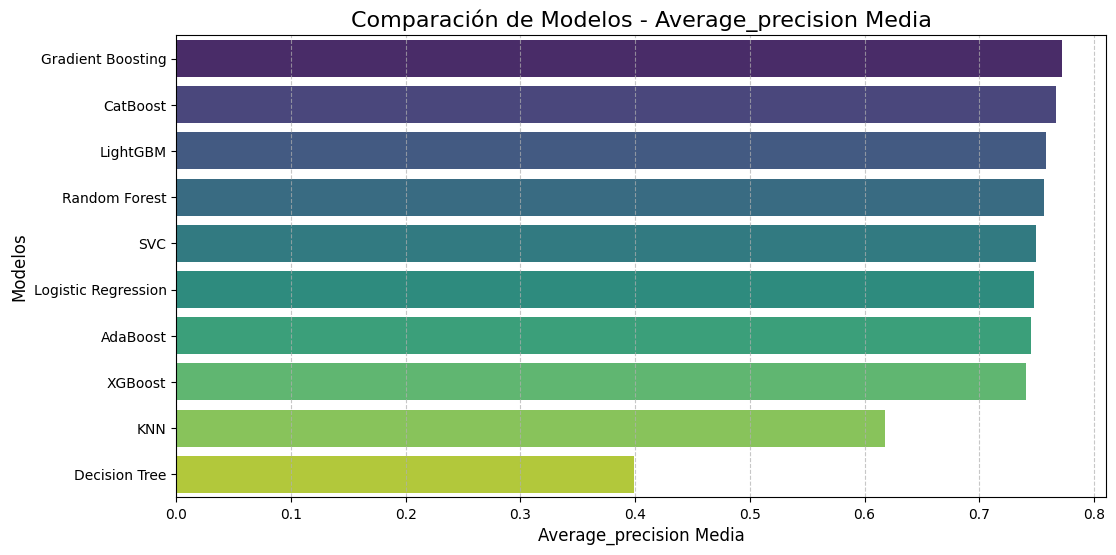

Modelo  Average_precision Media
5    Gradient Boosting                 0.772134
9             CatBoost                 0.767177
8             LightGBM                 0.758611
3        Random Forest                 0.756462
1                  SVC                 0.749396
0  Logistic Regression                 0.748108
6             AdaBoost                 0.744945
7              XGBoost                 0.740401
4                  KNN                 0.618210
2        Decision Tree                 0.399190

In [ ]:
tds.evaluar_modelos_clasificacion(X_train_selected, y_train, scoring="average_precision")

In [287]:
param_grid_gb = {
    'n_estimators': np.arange(50, 300, 25),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]  # <- corregido aquí
}

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

param_grid_lgb = {
    'n_estimators': np.arange(50, 150, 25),             # Menos árboles
    'learning_rate': np.linspace(0.03, 0.1, 4),         # No tan bajo como 0.01, ni tan alto como 0.3
    'num_leaves': [20, 31, 40],                         # Más pequeños
    'max_depth': [4, 5, 6],                             # Menor profundidad
    'subsample': [0.7, 0.8],                            # Regularización por filas
    'colsample_bytree': [0.6, 0.8],                     # Regularización por columnas
    'reg_alpha': [0.0, 0.1],                            # L1 regularization
    'reg_lambda': [0.0, 0.1],                           # L2 regularization
    'scale_pos_weight': [scale_pos_weight]             # Para clases desbalanceadas
}



param_grid_cat = {
    'iterations': np.arange(300, 600, 50),
    'learning_rate': np.linspace(0.01, 0.1, 6),
    'depth': [4, 6, 8],
    'l2_leaf_reg': [3, 5, 7],
    'border_count': [32, 64],
    'bagging_temperature': [0.0, 0.3, 0.5]
}



gb_model = GradientBoostingClassifier(random_state=42)
select_gb = RandomizedSearchCV(
    gb_model,
    param_distributions=param_grid_gb,
    n_iter=30,
    cv=5,
    scoring='f1',  
    n_jobs=-1,
    random_state=42
)

select_gb.fit(X_train_selected, y_train)

print("Mejor modelo Gradient Boosting:")
print(select_gb.best_params_)
print(classification_report(y_test, select_gb.predict(X_test_selected)))

lgb_model = LGBMClassifier(random_state=42)
select_lgb = RandomizedSearchCV(
    lgb_model,
    param_distributions=param_grid_lgb,
    n_iter=40,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
select_lgb.fit(X_train_selected, y_train)

print("Mejor modelo LightGBM:")
print(select_lgb.best_params_)
print(classification_report(y_test, select_lgb.predict(X_test_selected)))


cat_model = CatBoostClassifier(
    verbose=0,
    random_state=42,
    scale_pos_weight=scale_pos_weight
)
select_cat = RandomizedSearchCV(
    cat_model,
    param_distributions=param_grid_cat,
    n_iter=40,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
select_cat.fit(X_train_selected, y_train)

print("Mejor modelo CatBoost:")
print(select_cat.best_params_)
print(classification_report(y_test, select_cat.predict(X_test_selected)))




Mejor modelo Gradient Boosting:
{'subsample': 1.0, 'n_estimators': 125, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.042222222222222223}
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      2629
         1.0       0.76      0.58      0.66       453

    accuracy                           0.91      3082
   macro avg       0.85      0.77      0.80      3082
weighted avg       0.91      0.91      0.91      3082

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[LightGBM] [Info] Number of positive: 1845, number of negative: 10481
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1854
[LightGBM] [Info] Number of data points in the train set: 12326, number of used fea

In [ ]:
# Supongamos que usaste train_test_split antes
y_pred = select_lgb.predict(X_test_selected)
y_prob = select_lgb.predict_proba(X_test_selected)[:, 1]  # Probabilidades para ROC/AUC



In [250]:

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall (Sensibilidad):", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_prob))

# Reporte completo
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9055807916937054
Precision: 0.684931506849315
Recall (Sensibilidad): 0.6622516556291391
F1 Score: 0.6734006734006734
AUC-ROC: 0.9043824316483576

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.95      0.94      2629
         1.0       0.68      0.66      0.67       453

    accuracy                           0.91      3082
   macro avg       0.81      0.80      0.81      3082
weighted avg       0.90      0.91      0.90      3082



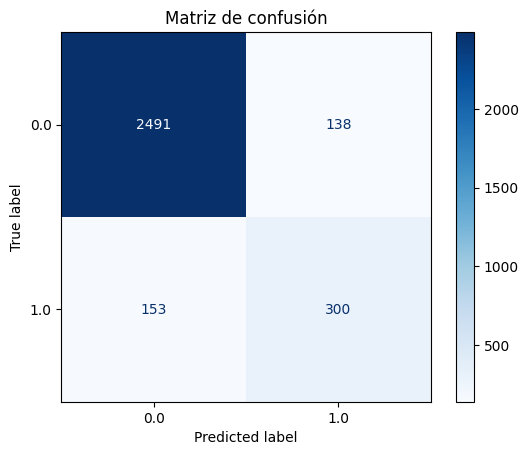

In [251]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_search.classes_)
disp.plot(cmap='Blues')
plt.title("Matriz de confusión")
plt.show()


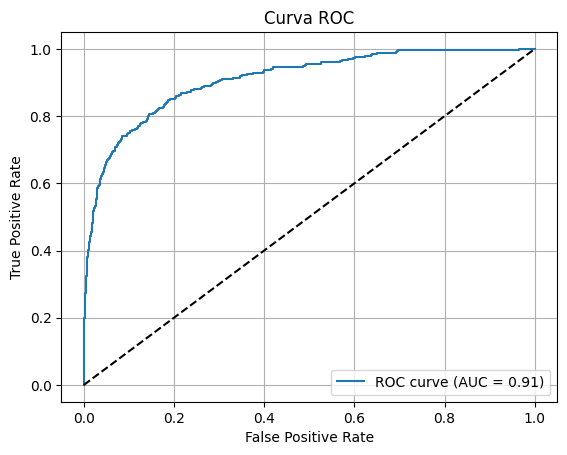

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc_score(y_test, y_prob))
plt.plot([0, 1], [0, 1], 'k--')  # línea diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Predict for 2021 data

In [330]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# 1️⃣ Cargar los nuevos datos (SIN el target)
new_data = pd.read_csv("../data/Prep_data/prep_data.csv")
new_data.set_index("SEQN", inplace=True)

y_true = new_data[target].copy()  # Guardar el target original

X_prep = new_data.copy()

X_prep.columns = X_prep.columns.str.replace(' ', '_')

X_prep.head()

Gender  Age(year)  Race  Country_of_birth  Income_category  \
SEQN                                                                   
130378.0     1.0       43.0   5.0               2.0              5.0   
130379.0     1.0       66.0   3.0               1.0              5.0   
130380.0     2.0       44.0   2.0               2.0              2.0   
130386.0     1.0       34.0   1.0               1.0              2.0   
130394.0     1.0       51.0   3.0               1.0              5.0   

          Height(m)  Weight(kg)  HDL-Cholesterol(mmol/L)  \
SEQN                                                       
130378.0     1.8034   86.182480                     1.16   
130379.0     1.7780   99.790240                     1.55   
130380.0     1.5240   68.038800                     1.27   
130386.0     1.7272   90.718400                     1.19   
130394.0     1.7780   78.925008                     1.24   

          Total_Cholesterol(mmol/L)  Glycohemoglobin(%)  Insulin_(pmol/L)  \
SEQN                                                                        
130378.0                       6.83                 5.6             93.18   
130379.0                       5.53                 5.6            119.46   
130380.0                       4.84                 6.2             97.98   
130386.0                       4.73                 5.1             68.28   
130394.0                       4.73                 4.8             43.20   

          High_blood_pressure?  100_cigarrettes_life?  Diabetes_diagnosticated  
SEQN                                                                            
130378.0                   1.0                    1.0                      0.0  
130379.0                   1.0                    1.0                      0.0  
130380.0                   2.0                    2.0                      1.0  
130386.0                   2.0                    1.0                      0.0  
130394.0                   2.0                    2.0                      0.0

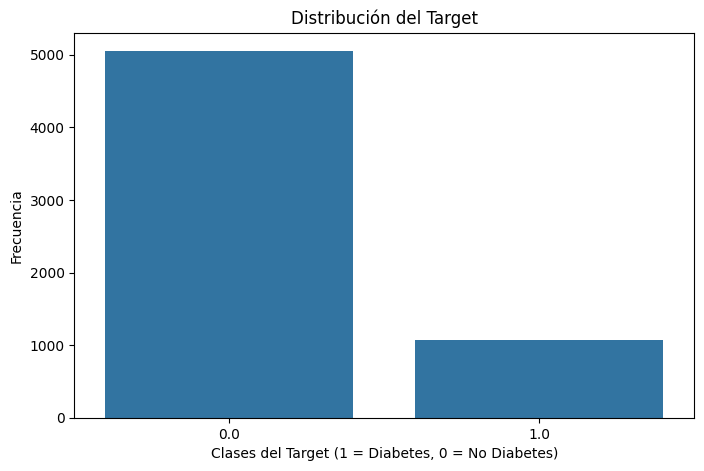

In [331]:
plt.figure(figsize=(8, 5))
sns.countplot(x=new_data["Diabetes_diagnosticated"])  # Gráfico de barras para contar categorías
plt.xlabel("Clases del Target (1 = Diabetes, 0 = No Diabetes)")
plt.ylabel("Frecuencia")
plt.title("Distribución del Target")
plt.show()


In [332]:
new_data[target].value_counts(normalize=True) * 100

Diabetes_diagnosticated
0.0    82.508574
1.0    17.491426
Name: proportion, dtype: float64

### Feature engineering

In [333]:
# Cálculo del IMC (Índice de Masa Corporal)
X_prep['BMI'] = X_prep['Weight(kg)'] / (X_prep['Height(m)'] ** 2)

# Ratio Colesterol Total / HDL (indicador de riesgo cardiovascular)
X_prep['CHOL_ratio'] = X_prep['Total_Cholesterol(mmol/L)'] / X_prep['HDL-Cholesterol(mmol/L)']

# Agrupar edad en categorías clínicas
def age_group(age):
    if age < 18:
        return 1.0 #'child'
    elif age < 40:
        return 2.0 #'young_adult'
    elif age < 60:
        return 3.0 #'adult'
    else:
        return 4.0 #'senior'
X_prep['Age_group'] = X_prep['Age(year)'].apply(age_group)

# Categorías de IMC según la OMS
def bmi_category(bmi):
    if bmi < 18.5:
        return 1.0 #'underweight'
    elif bmi < 25:
        return 2.0 #'normal'
    elif bmi < 30:
        return 3.0 #'overweight'
    else:
        return 4.0 #'obese'
X_prep['BMI_category'] = X_prep['BMI'].apply(bmi_category)

# Indicador binario de colesterol total elevado
X_prep['High_cholesterol'] = (X_prep['Total_Cholesterol(mmol/L)'] > 6.2).astype(int)

# Indicador binario de HbA1c elevado (≥ 6.5% → diagnóstico de diabetes)
X_prep['High_HbA1c'] = (X_prep['Glycohemoglobin(%)'] >= 6.5).astype(int)

# Interacción IMC x HbA1c
X_prep['BMI_HbA1c'] = X_prep['BMI'] * X_prep['Glycohemoglobin(%)']

# Indicador binario de insulina alta (posible resistencia a insulina)
X_prep['High_insulin'] = (X_prep['Insulin_(pmol/L)'] > 90).astype(int)

# Indicador de riesgo cardiovascular simple (edad alta, IMC alto, colesterol alto, hipertensión)
X_prep['Cardio_risk'] = (
    (X_prep['Age(year)'] > 60).astype(int) +
    (X_prep['BMI'] > 30).astype(int) +
    (X_prep['Total_Cholesterol(mmol/L)'] > 6.2).astype(int) +
    (X_prep['High_blood_pressure?'] == 1).astype(int)
)

X_prep.head()

X_prep.to_csv("../data/Prep_data/prep_data_cleaned.csv", index = False)

X_prep = new_data.drop(target, axis=1)  # Quitar el target


### logaritmic transformation

In [308]:
X_prep['Insulin_(pmol/L)'] = np.log1p(X_prep['Insulin_(pmol/L)'])
X_prep['Glycohemoglobin(%)'] = np.log1p(X_prep['Glycohemoglobin(%)'])
X_prep['BMI'] = np.log1p(X_prep['BMI'])
X_prep['CHOL_ratio'] = np.log1p(X_prep['CHOL_ratio'])
X_prep['BMI_HbA1c'] = np.log1p(X_prep['BMI_HbA1c'])
X_prep['HDL-Cholesterol(mmol/L)'] = np.log1p(X_prep['HDL-Cholesterol(mmol/L)'])
X_prep['Total_Cholesterol(mmol/L)'] = np.log1p(X_prep['Total_Cholesterol(mmol/L)'])

In [309]:
# Suponiendo que ya entrenaste tu scaler así:
scaler = StandardScaler()
scaler.fit(X_train[num_features])  # entrenado con datos originales

# Entonces para nuevos datos:
X_prep_scaled_num = pd.DataFrame(
    scaler.transform(X_prep[num_features]),  # ⚠️ .transform, NO .fit_transform
    columns=num_features,
    index=X_prep.index
)

# Recuperar columnas categóricas
X_prep_scaled = pd.concat([X_prep_scaled_num, X_prep[cat_features]], axis=1)


### Preprocesing

In [312]:
y_pred_nuevo = search_lgb.predict(X_prep_scaled)
y_prob_nuevo = search_lgb.predict_proba(X_prep)[:, 1]


### Evaluation

In [313]:

print("Accuracy:", accuracy_score(y_true, y_pred_nuevo))
print("Precision:", precision_score(y_true, y_pred_nuevo))
print("Recall:", recall_score(y_true, y_pred_nuevo))
print("F1 Score:", f1_score(y_true, y_pred_nuevo))
print("AUC-ROC:", roc_auc_score(y_true, y_prob_nuevo))


Accuracy: 0.8912297893189612
Precision: 0.6590730557737627
Recall: 0.7833800186741363
F1 Score: 0.7158703071672355
AUC-ROC: 0.6260989352193767


### Comparation with the real prediction

In [ ]:
resultados = pd.DataFrame({
    'Real': y_true,
    'Predicción': y_pred_nuevo,
    'Probabilidad': y_prob_nuevo
}, index=X_prep.index)


In [334]:
resultados['Acierto'] = resultados['Real'] == resultados['Predicción']
print(resultados['Acierto'].value_counts())
print(f"Accuracy en datos nuevos: {resultados['Acierto'].mean():.2f}")


Acierto
True     5457
False     666
Name: count, dtype: int64
Accuracy en datos nuevos: 0.89


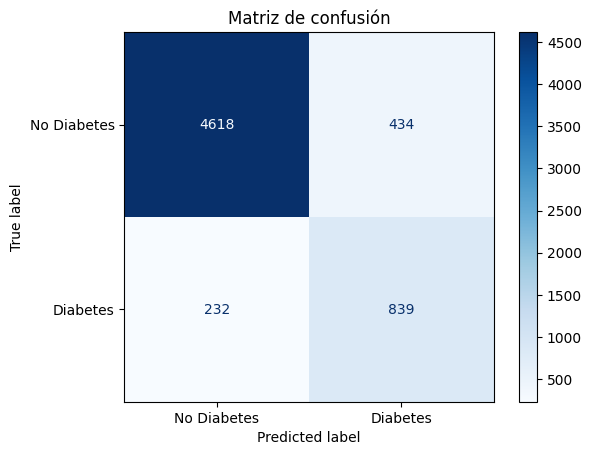

In [316]:

ConfusionMatrixDisplay.from_predictions(resultados['Real'], resultados['Predicción'], 
                                        cmap='Blues', display_labels=['No Diabetes', 'Diabetes'])
plt.title("Matriz de confusión")
plt.grid(False)
plt.show()


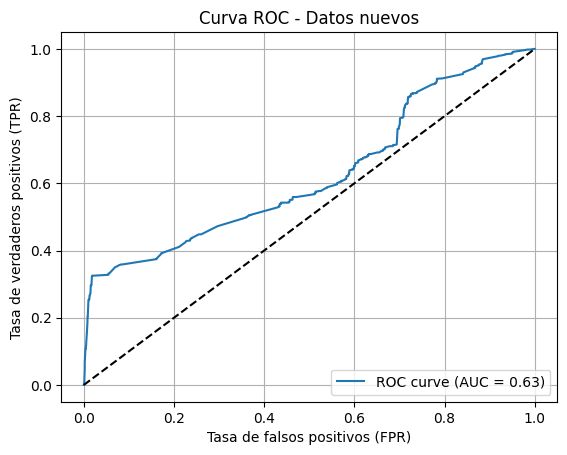

In [317]:

fpr, tpr, thresholds = roc_curve(resultados['Real'], resultados['Probabilidad'])
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc_score(resultados['Real'], resultados['Probabilidad']))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - Datos nuevos')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [318]:
resultados_sorted = resultados.sort_values('Probabilidad', ascending=False)
print(resultados_sorted.head(10))  # Casos con mayor probabilidad de diabetes
print(resultados_sorted.tail(10)) # Casos con menor probabilidad


          Real  Predicción  Probabilidad  Acierto
SEQN                                             
136607.0   0.0         1.0      0.794753    False
130687.0   1.0         1.0      0.791184     True
132169.0   1.0         1.0      0.791184     True
123260.0   0.0         0.0      0.791184     True
139738.0   1.0         0.0      0.791184    False
124025.0   1.0         1.0      0.790863     True
138255.0   1.0         1.0      0.790489     True
116129.0   0.0         1.0      0.790489    False
120416.0   1.0         1.0      0.790489     True
139026.0   0.0         1.0      0.790489    False
          Real  Predicción  Probabilidad  Acierto
SEQN                                             
137339.0   0.0         0.0      0.735527     True
132868.0   0.0         0.0      0.735527     True
115161.0   0.0         0.0      0.735527     True
119212.0   0.0         0.0      0.735527     True
142155.0   0.0         0.0      0.735527     True
138765.0   0.0         0.0      0.735527     True


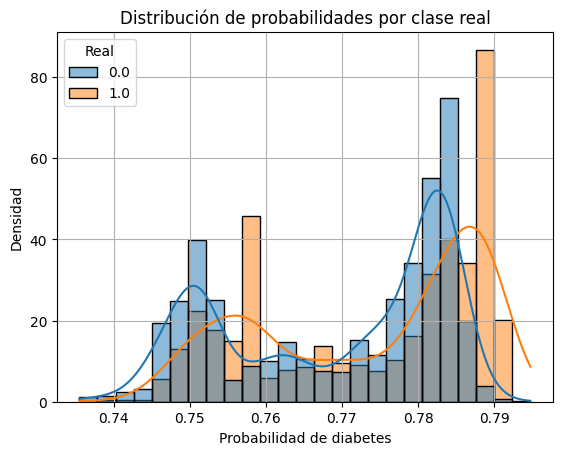

In [319]:

sns.histplot(data=resultados, x='Probabilidad', hue='Real', bins=25, kde=True, stat='density', common_norm=False)
plt.title("Distribución de probabilidades por clase real")
plt.xlabel("Probabilidad de diabetes")
plt.ylabel("Densidad")
plt.grid()
plt.show()
